# Walter's code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gc
from PIL import Image
import requests
from transformers import pipeline
import os
from transformers import AutoProcessor,AutoModel
import torch

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load the embedding model
model = AutoModel.from_pretrained("Idan0405/ClipMD",trust_remote_code=True)
processor = AutoProcessor.from_pretrained("Idan0405/ClipMD")

config.json: 100%|████████████████████████████████████| 4.43k/4.43k [00:00<00:00, 308kB/s]
ClipMDModel.py: 100%|█████████████████████████████████| 5.76k/5.76k [00:00<00:00, 426kB/s]
A new version of the following files was downloaded from https://huggingface.co/Idan0405/ClipMD:
- ClipMDModel.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
pytorch_model.bin: 100%|███████████████████████████████| 605M/605M [00:12<00:00, 49.3MB/s]
tokenizer_config.json: 100%|██████████████████████████████| 999/999 [00:00<00:00, 351kB/s]
vocab.json: 100%|██████████████████████████████████████| 862k/862k [00:00<00:00, 19.8MB/s]
merges.txt: 100%|██████████████████████████████████████| 525k/525k [00:00<00:00, 22.2MB/s]
tokenizer.json: 100%|████████████████████████████████| 2.22M/2.22M [00:00<00:00, 17.5MB/s]
special_tokens_map.json: 100%|████████████████████████████| 472/472 [00:00<00:00, 204kB/s]


In [3]:
#load the mask model
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)

preprocessor_config.json: 100%|██████████████████████████| 466/466 [00:00<00:00, 20.1kB/s]


In [7]:
#get list of image filenames
# images_folder = '../../../gobi1/data/ChestXray8/images/'
images_folder = '/data/healthy-ml/gobi1/data/ChestXray8/images/'
image_list = os.listdir(images_folder)

In [8]:
# #select how many images you want to compute masks for
# num_images = 20
# #loop through images, compute their mask
# #all_masks is a list of masks; all_masks[i] is a list of the masks for the ith image
# all_masks = []
# for i in range(num_images):
#     raw_image = Image.open(images_folder + image_list[i]).convert("RGB")
#     outputs = generator(raw_image, points_per_batch=128, predicted_iou = 0.4)
#     masks = outputs["masks"]
#     all_masks.append(masks)
#     show_masks_on_image(raw_image, masks)

#select how many images you want to compute masks for
num_images = 20

#loop through images, compute their mask
all_masks = [] #list of masks; all_masks[i] is a list of the masks for the ith image
embeds = [] #list of embeddings; embeds[i] is a list of the embeddings for the masked images from image i 
all_masked_imgs = [] #list of masked out images; all_masked_imgs[i] is a list of the masked images from image i
for i in range(num_images):
    print(f"{i+1}/{num_images}")
    embed_list = []
    masked_img_list = []
    raw_image = Image.open(images_folder + image_list[i]).convert("RGB")
    np_image = np.array(raw_image)
    
    #get the masks 
    outputs = generator(raw_image, points_per_batch=128, predicted_iou = 0.4)
    masks = outputs["masks"]
    all_masks.append(masks)
    # show_masks_on_image(raw_image, masks)
    #loop through the masks
    for _mask in masks:
        masked_image = np_image * _mask[:, :, np.newaxis] #mask out the image for the th image

        #embed the masked image
        inputs = processor(images=[masked_image], return_tensors="pt").to('cpu') 
        image_features = model.get_image_features(**inputs).detach().to('cpu').numpy()
        embed_list.append(image_features)
        masked_img_list.append(masked_image)
    all_masked_imgs.append(masked_img_list)
    embeds.append(embed_list)

1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20


/data/healthy-ml/scratch/qixuanj/anaconda3/envs/control/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


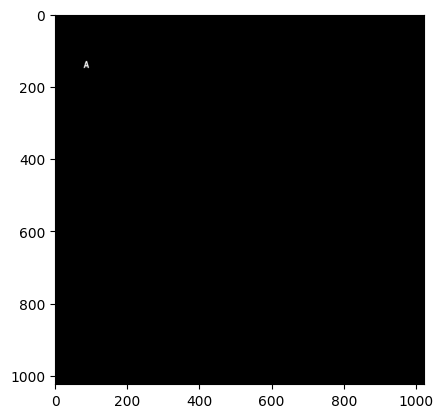

In [12]:
plt.imshow(sorted_img_masks[11])
plt.show()

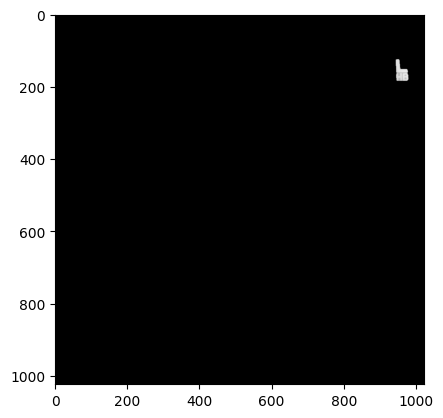

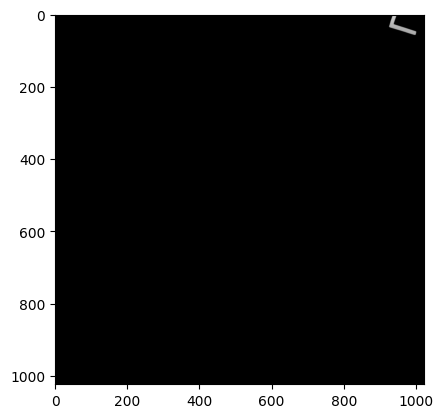

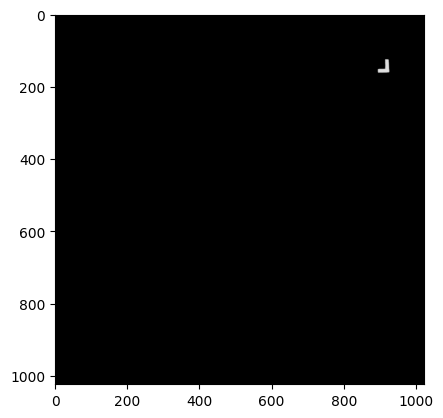

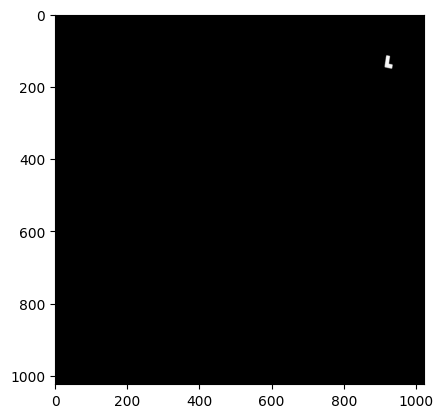

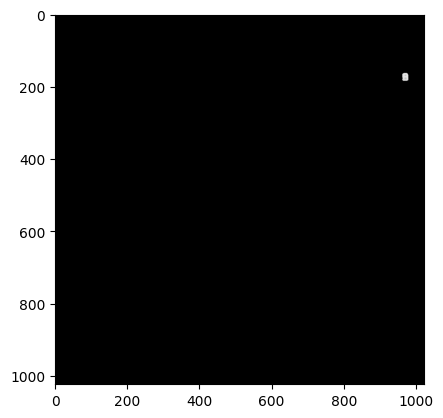

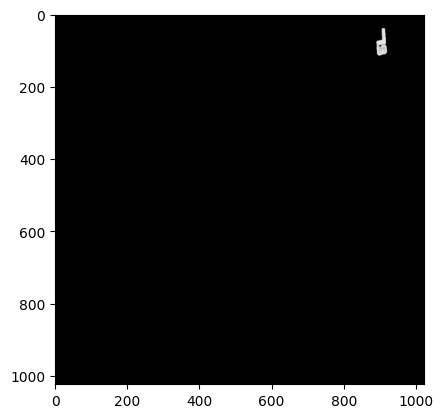

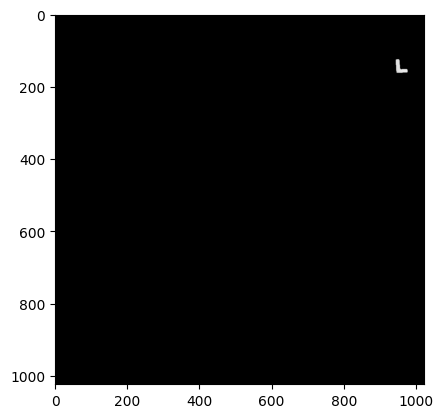

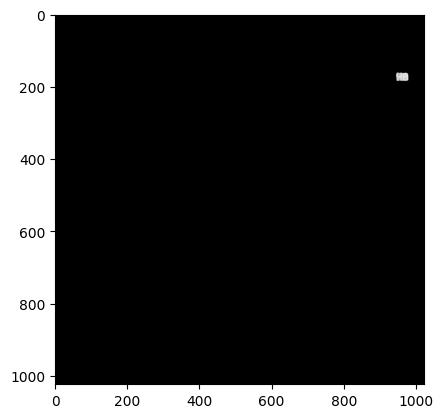

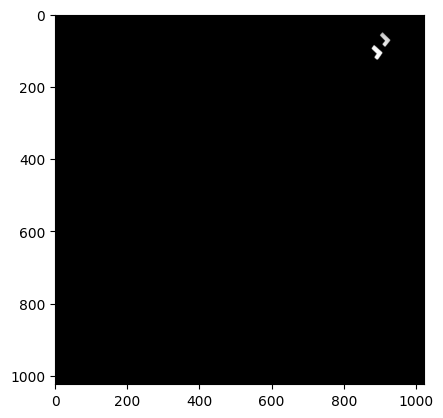

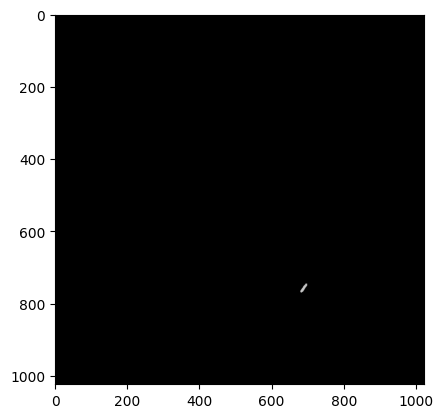

In [9]:
#find the index of a mask that you want to do the similarity search on
ref_embed_indx = 11 #the 11th mask corresponds to one of the random "L"s on the images

flat_masked_image_list = [
    x
    for xs in all_masked_imgs
    for x in xs
]

flat_embeds = [
    x
    for xs in embeds
    for x in xs
]

cos = torch.nn.CosineSimilarity(dim=0)

#find the embeddings that are most similar to the reference embedding
sim_list = []
for i in range(len(flat_embeds)):
    sim_list.append(cos(torch.tensor(flat_embeds[ref_embed_indx][0]), torch.tensor(flat_embeds[i][0])).item())

#plot the maske dimages most similar to the reference mask
sorted_img_masks = [x for _, x in sorted(zip(sim_list, flat_masked_image_list), reverse=True)]
for i in range(10):
    plt.imshow(sorted_img_masks[i])
    plt.show()

# Debug the histogram based sam mask generation

In [4]:
import torch
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import supervision as sv
import skimage
from tqdm import tqdm 
import numpy as np
import torchvision
from torchvision import transforms
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.cm import get_cmap
from sklearn.metrics import silhouette_score
from glob import glob
import pickle
import gc

from transformers import pipeline
from transformers import AutoProcessor,AutoModel

import networkx as nx
from networkx.algorithms.components.connected import connected_components

def to_graph(l):
    G = nx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for mask in masks:
        show_mask(mask, ax=ax, random_color=True)
    plt.axis("off")
    plt.show()
    del mask
    gc.collect()

def get_devices(gpus):
    if len(gpus) == 0:
        device_ids = None
        device = torch.device('cpu')
        print('Warning! Computing on CPU')
    elif len(gpus) == 1:
        device_ids = None
        device = torch.device('cuda:' + str(gpus[0]))
    else:
        device_ids = [int(i) for i in gpus]
        device = torch.device('cuda:' + str(min(device_ids)))
    return device, device_ids

device, device_ids = get_devices([0])

/data/healthy-ml/scratch/qixuanj/anaconda3/envs/spurious_imagenet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load the embedding model
model = AutoModel.from_pretrained("Idan0405/ClipMD",trust_remote_code=True)
processor = AutoProcessor.from_pretrained("Idan0405/ClipMD")

#load the mask model
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)

In [5]:
# Load the MIMIC-CXR dataset 

metadata = pd.read_csv("/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/mimic-cxr-2.0.0-metadata.csv.gz")
# Get only frontal images, either PA or AP 
meta = metadata[(metadata['ViewPosition'] == "PA") | (metadata['ViewPosition'] == "AP")]
meta['img_path'] = meta.apply(lambda row: 'p' + str(row['subject_id'])[:2] + '/p' + str(row['subject_id']) + \
                               '/s' + str(row['study_id']) + '/' + row['dicom_id'] + '.jpg', axis = 1)
labels = pd.read_csv("/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/mimic-cxr-2.0.0-chexpert.csv.gz")
print(len(labels))
support_device_labels = labels[labels['Support Devices'] == 1]
print(len(support_device_labels))
meta = meta[meta['study_id'].isin(support_device_labels['study_id'])]
print(len(meta))

/tmp/ipykernel_829188/250168609.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['img_path'] = meta.apply(lambda row: 'p' + str(row['subject_id'])[:2] + '/p' + str(row['subject_id']) + \


227827
66558
73294


In [7]:
img_dir = "/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/"

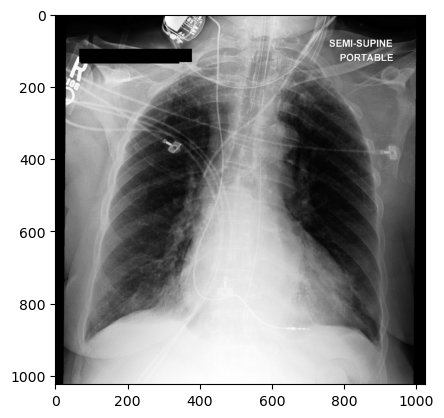

In [51]:
img = cv2.imread(img_dir + meta['img_path'].iloc[4])
plt.imshow(img, cmap='gray')
plt.show()

In [32]:
# sam_result = generator(img, points_per_batch=128, predicted_iou = 0.4)
# masks = sam_result["masks"]

In [37]:
# print(len(sam_result["masks"]))

40


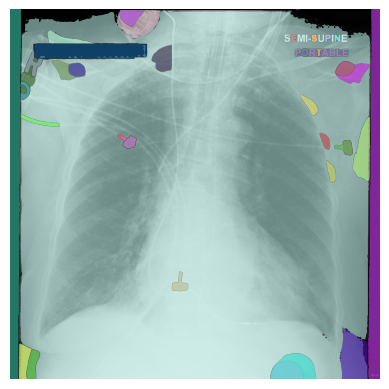

In [33]:
# plt.imshow(np.array(img))
# ax = plt.gca()
# for mask in sam_result["masks"]:
#     show_mask(mask, ax=ax, random_color=True)
# plt.axis("off")
# plt.show()

In [34]:
from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint='/data/healthy-ml/scratch/qixuanj/generative_validation/sam_vit_h_4b8939.pth')
sam.to(device=DEVICE)

from segment_anything import SamAutomaticMaskGenerator

In [52]:
mask_generator = SamAutomaticMaskGenerator(sam, 
                    points_per_side=128, # 32 
                    pred_iou_thresh=0.88, # 0.88 
                    stability_score_thresh=0.96, # 0.95
                    crop_n_layers=0,
                    crop_n_points_downscale_factor=2,
                    min_mask_region_area=100, # 0
                    box_nms_thresh= 0.7, #0.7
                    crop_nms_thresh= 0.7, # 0.7
                    )

image_rgb = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_rgb)
print(len(sam_result))

58


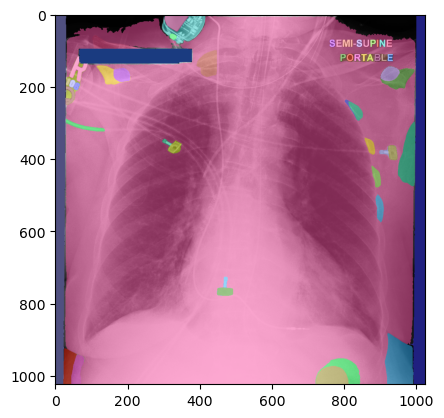

In [53]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result)
annotated_image = mask_annotator.annotate(np.array(img), detections)
plt.figure()
plt.imshow(annotated_image)

In [70]:
mask.shape

(1024, 1024, 3)

## Histogram grouping

In [55]:
intersect_matrix = np.zeros((len(sam_result), len(sam_result)))                      
for j in range(len(sam_result)):
    mask = np.repeat(sam_result[j]['segmentation'][:, :, np.newaxis], 3, axis=2)
    img_copy1 = img.copy()
    img_copy1[~mask] = 0
    hist_img1 = cv2.calcHist([img_copy1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    hist_img1[0, 0, 0] = 0 
    hist_img1 = cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    for k in range(j + 1, len(sam_result)):
        mask = np.repeat(sam_result[k]['segmentation'][:, :, np.newaxis], 3, axis=2)
        img_copy2 = img.copy()
        img_copy2[~mask] = 0
        hist_img2 = cv2.calcHist([img_copy2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
        hist_img2[0, 0, 0] = 0 
        hist_img2 = cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

        intersect_matrix[j, k] =  cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_INTERSECT)

In [60]:
intersect_matrix.min()

0.0

In [61]:
intersect_matrix.max()

54.13591926638037

In [62]:
intersect_thresholds

[8.352168914815412,
 9.45911096788477,
 10.738899861089887,
 12.150724546518177,
 14.479110175557427]

In [64]:
np.linspace(0.95, 0.99, 5)

array([0.95, 0.96, 0.97, 0.98, 0.99])

In [65]:
# Histogram doesn't work -> group all them together 

intersect_matrix2 = intersect_matrix.copy()
intersect_matrix2[intersect_matrix2 == 0] = np.nan
intersect_thresholds = []
for q in np.linspace(0.95, 0.99, 5):
    intersect_thresholds.append(np.nanquantile(intersect_matrix2, q = q))
    
for intersect_threshold in intersect_thresholds:
    intersect_matrix2 = intersect_matrix.copy()
    intersect_matrix2[intersect_matrix2 < intersect_threshold] = 0
    pairs_list = list(zip(np.nonzero(intersect_matrix2)[0], np.nonzero(intersect_matrix2)[1]))

    G = to_graph(pairs_list)
    pattern = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    pattern = [list(s) for s in pattern]
    print(pattern)
    if len(pattern) > 1: 
        break

masks = []
for pa in pattern: 
    mask = np.full(img.shape[:2], False)
    for idx in pa: 
        mask = mask | sam_result[idx]['segmentation']
    masks.append(mask)

[[1, 3, 4, 5, 6, 7, 8, 11, 13, 14, 16, 18, 23, 25, 26, 31, 34, 38, 47, 48, 49, 52, 55]]
[[1, 3, 5, 6, 7, 8, 11, 13, 14, 16, 18, 23, 25, 26, 31, 34, 38, 47, 48, 49, 52, 55]]
[[1, 3, 5, 6, 7, 8, 11, 13, 14, 16, 23, 25, 26, 31, 34, 38, 47, 48, 52, 55]]
[[1, 34, 5, 6, 7, 8, 38, 11, 13, 14, 16, 52, 23, 55, 25, 26, 31]]
[[1, 34, 5, 6, 7, 8, 38, 13, 16, 52, 23, 55, 31]]


In [66]:
masks

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])]

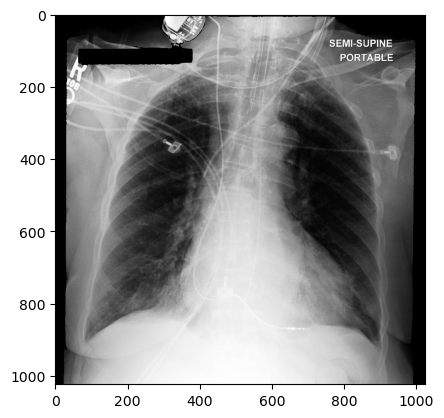

In [67]:
mask_imgs = []
for m in masks: 
    mask = np.repeat(m[:, :, np.newaxis], 3, axis=2)
    img_copy = image_rgb.copy()
    img_copy[~mask] = 0
    mask_imgs.append(img_copy)
    plt.imshow(img_copy)
    plt.show()

## SSIM

In [68]:
from skimage import metrics

In [69]:
ssim_matrix = np.zeros((len(sam_result), len(sam_result)))
                            
for j in tqdm(range(len(sam_result))):
    mask = np.repeat(sam_result[j]['segmentation'][:, :, np.newaxis], 3, axis=2)
    img_copy1 = img.copy()
    img_copy1[~mask] = 0
    image1_gray = cv2.cvtColor(img_copy1, cv2.COLOR_BGR2GRAY)
    for k in range(j + 1, len(sam_result)):
        mask = np.repeat(sam_result[k]['segmentation'][:, :, np.newaxis], 3, axis=2)
        img_copy2 = img.copy()
        img_copy2[~mask] = 0
        image2_gray = cv2.cvtColor(img_copy2, cv2.COLOR_BGR2GRAY)

        ssim_matrix[j, k] =  metrics.structural_similarity(image1_gray, image2_gray, full=False)

100%|█████████████████████████████████████████████████████| 58/58 [03:09<00:00,  3.28s/it]


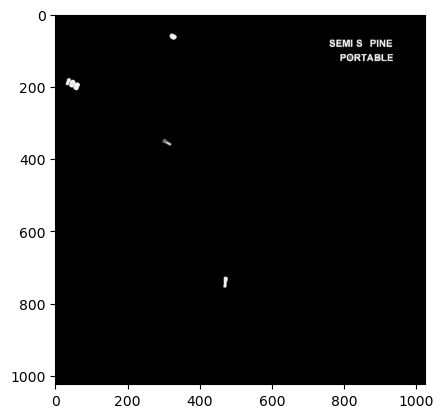

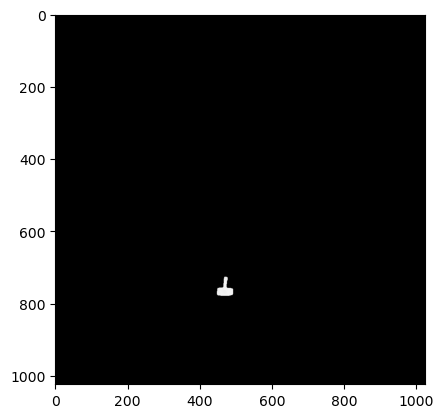

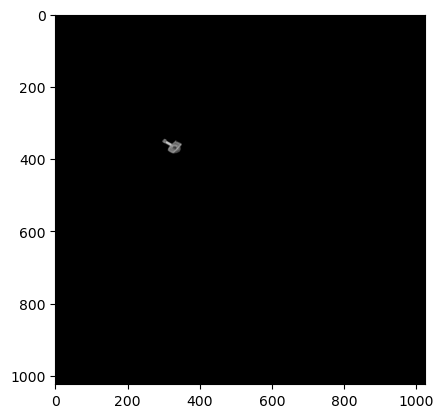

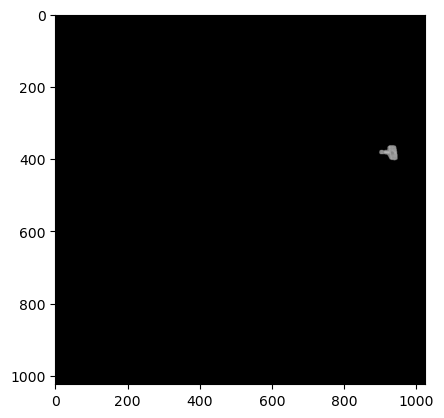

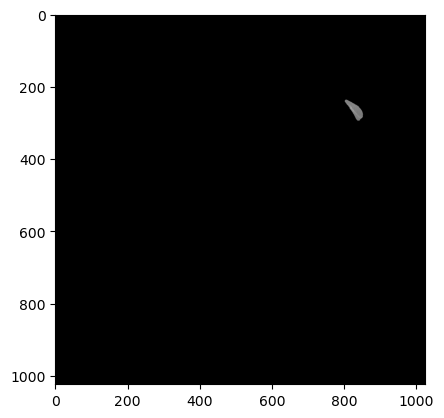

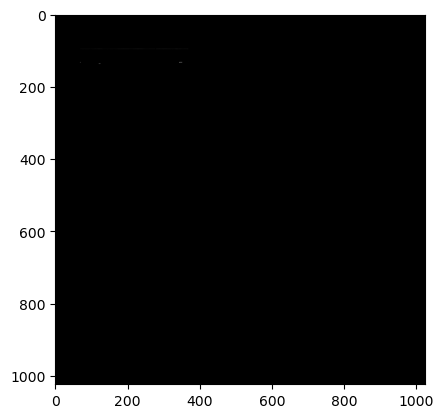

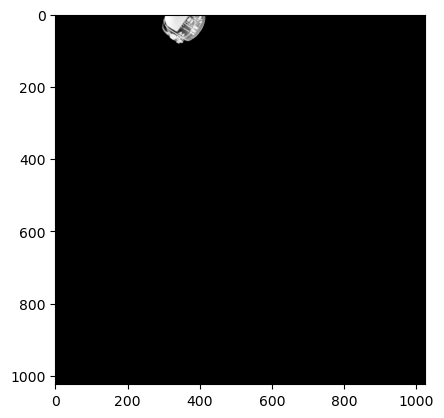

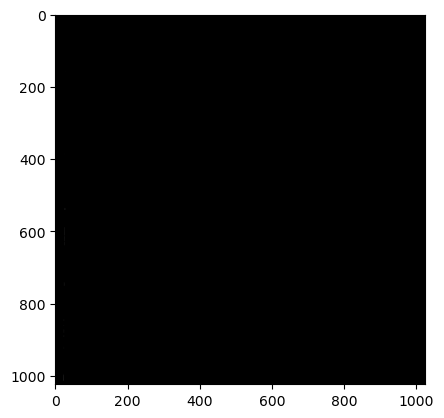

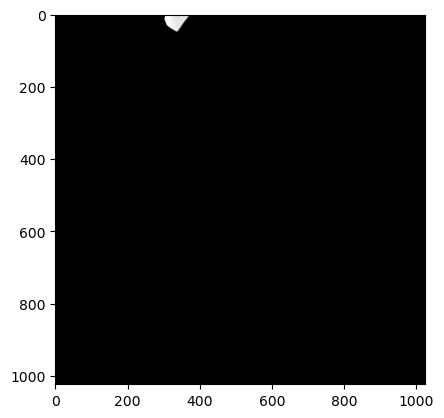

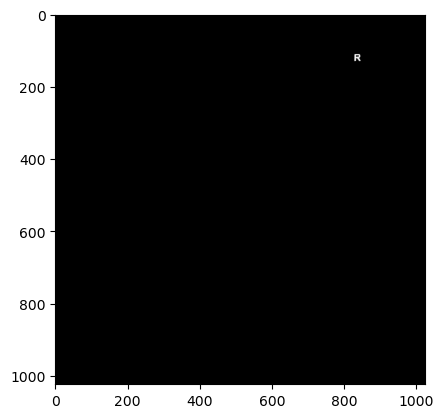

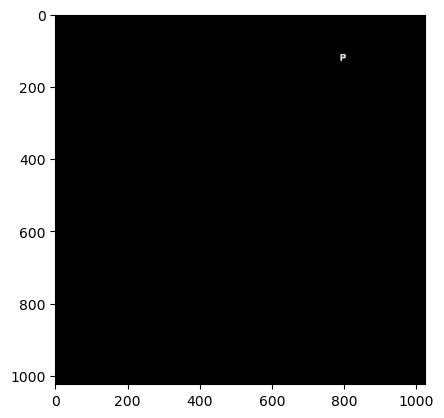

In [77]:
ssim_matrix2 = ssim_matrix.copy()
ssim_matrix2[ssim_matrix2 == 0] = np.nan
ssim_thresholds = []
for q in np.linspace(0.90, 0.99, 10):
    ssim_thresholds.append(np.nanquantile(ssim_matrix2, q = q))

for ssim_threshold in ssim_thresholds:
    ssim_matrix2 = ssim_matrix.copy()
    ssim_matrix2[ssim_matrix2 < ssim_threshold] = 0
    pairs_list = list(zip(np.nonzero(ssim_matrix2)[0], np.nonzero(ssim_matrix2)[1]))

    G = to_graph(pairs_list)
    pattern = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    pattern = [list(s) for s in pattern]
    if len(pattern) > 2: 
        break

masks = []
for p in pattern: 
    mask = np.full(img.shape[:2], False)
    for idx in p: 
        mask = mask | sam_result[idx]['segmentation']
    masks.append(mask)

# Add the top 3 predicted_iou SAM segmentation masks  
topn = min(len(sam_result), 3)
for idx in range(topn):
    mask = np.full(img.shape[:2], False)
    mask = mask | sam_result[idx]['segmentation']
    masks.append(mask)

stability_scores = []
for i in range(len(sam_result)): 
    stability_scores.append(sam_result[i]['stability_score'])
topn_idx = np.argpartition(np.array(stability_scores), -topn)[-topn:]

# Add the top 3 stability_score SAM segmentation masks
for idx in topn_idx: 
    mask = np.full(img.shape[:2], False)
    mask = mask | sam_result[idx]['segmentation']
    masks.append(mask)

for m in masks: 
    mask = np.repeat(m[:, :, np.newaxis], 3, axis=2)
    img_copy = image_rgb.copy()
    img_copy[~mask] = 0
    plt.imshow(img_copy)
    plt.show()

1.0201432704925537


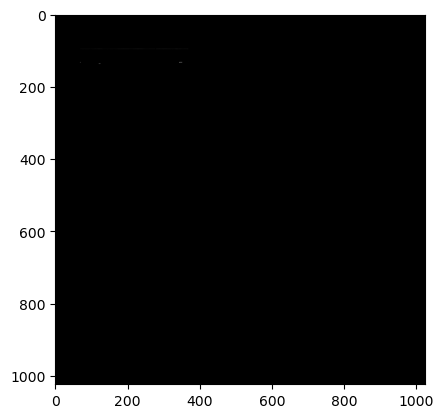

0.9932769536972046


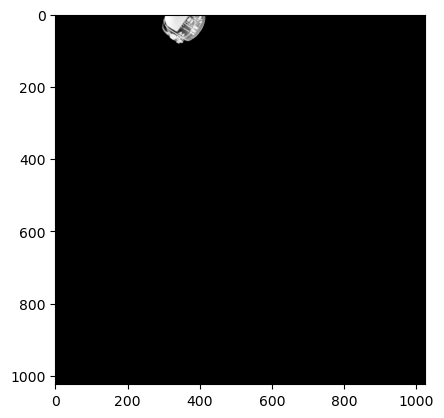

0.9869931936264038


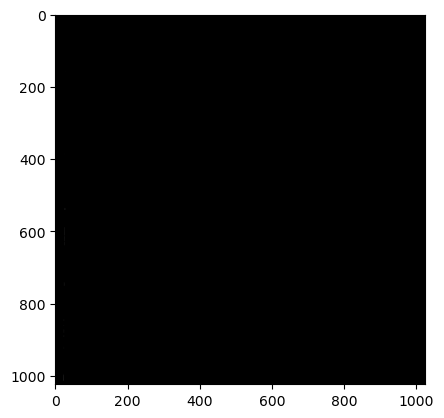

0.9854685664176941


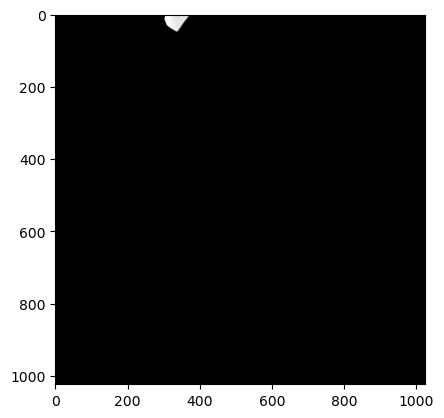

0.984433650970459


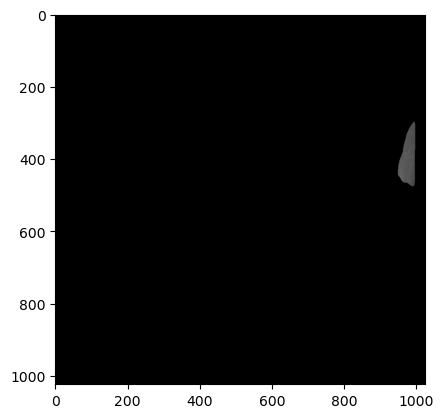

0.9794203639030457


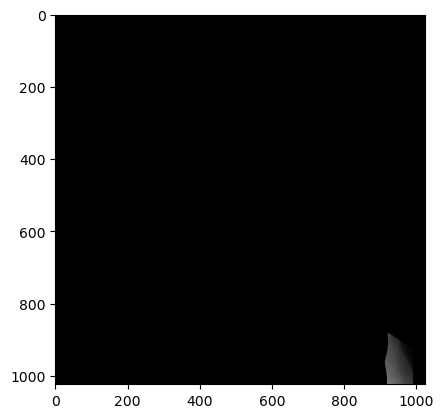

0.9723736047744751


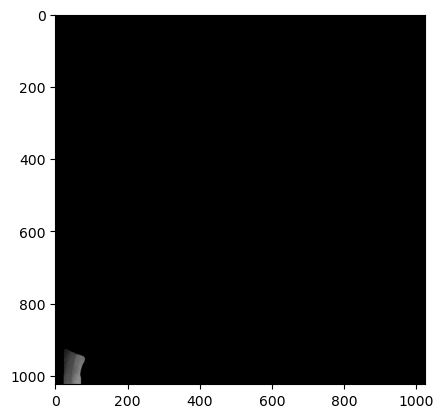

0.9711285829544067


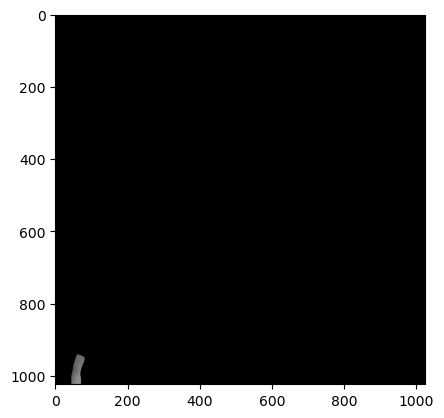

0.9674010276794434


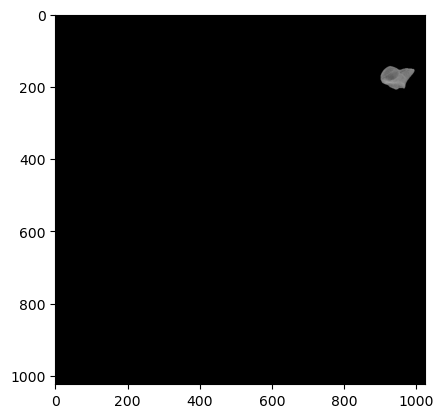

0.9673601388931274


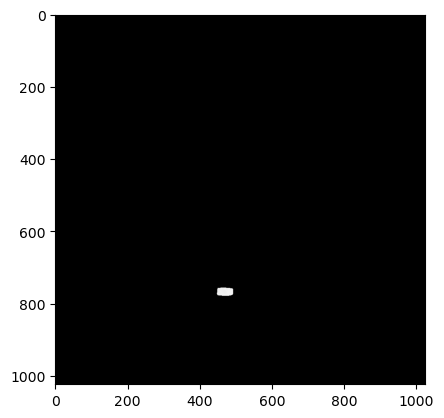

0.9655457139015198


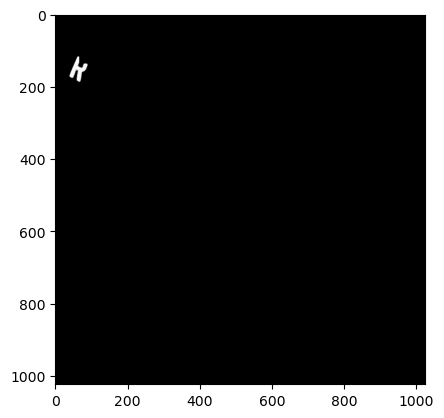

0.963760256767273


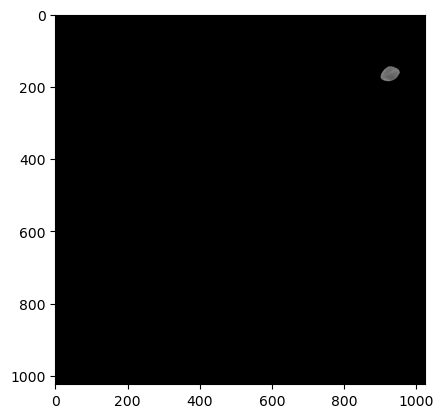

0.9617981314659119


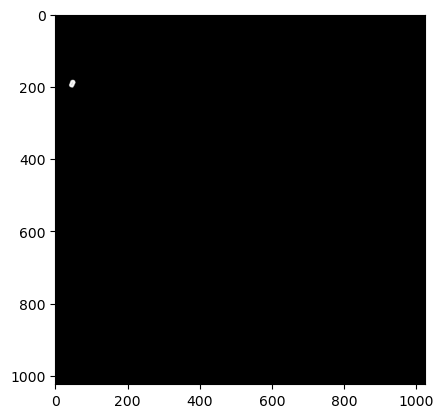

0.961747407913208


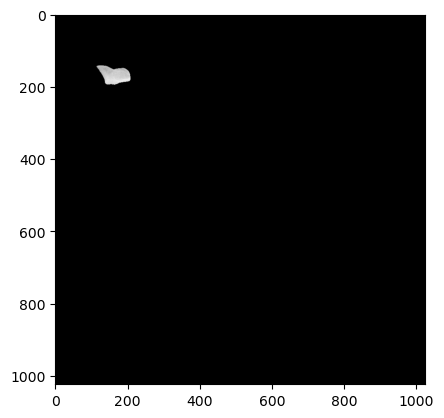

0.9567761421203613


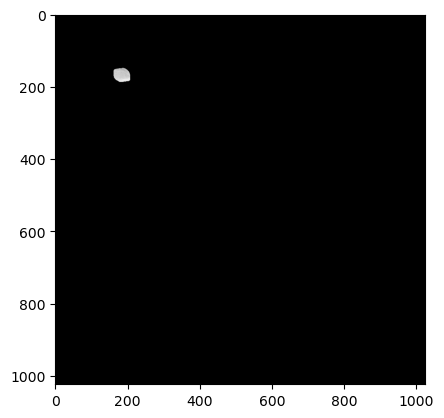

0.9551042914390564


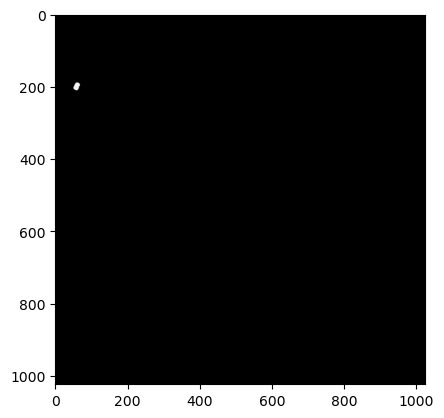

0.9540989398956299


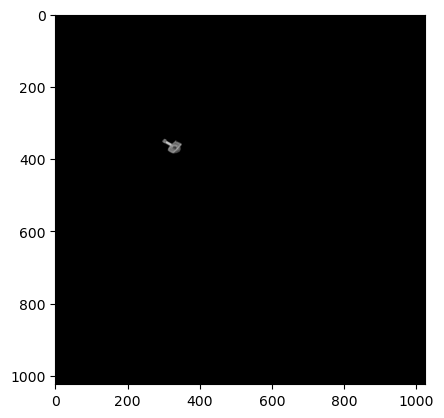

0.9539294242858887


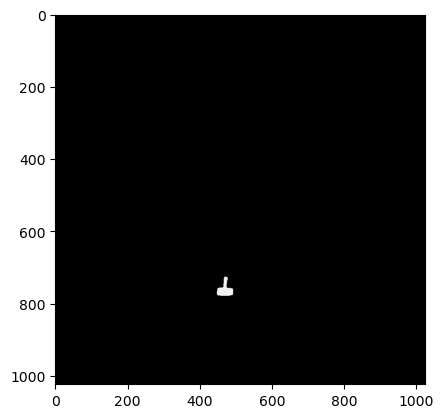

0.9536467790603638


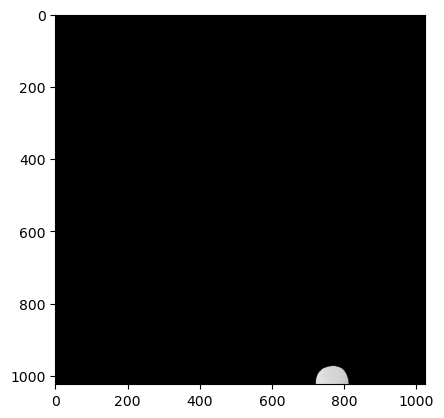

0.9523406624794006


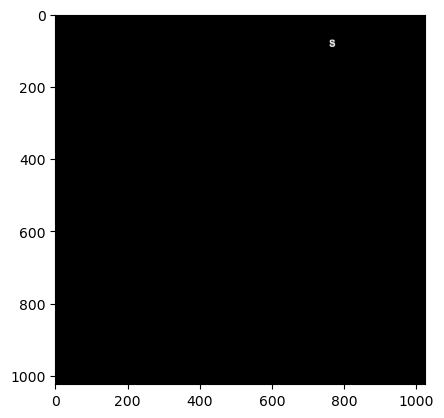

0.9506109952926636


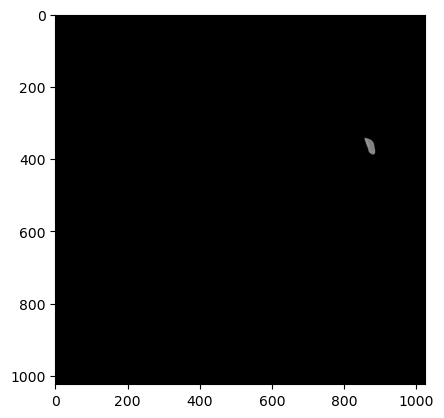

0.9480988383293152


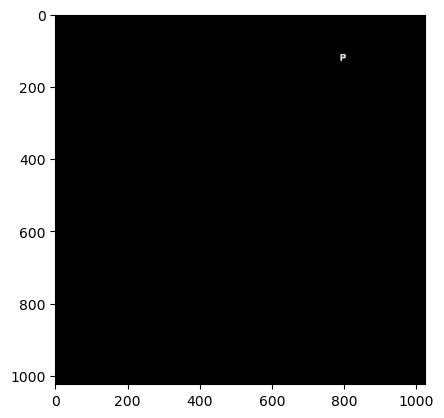

0.9473026990890503


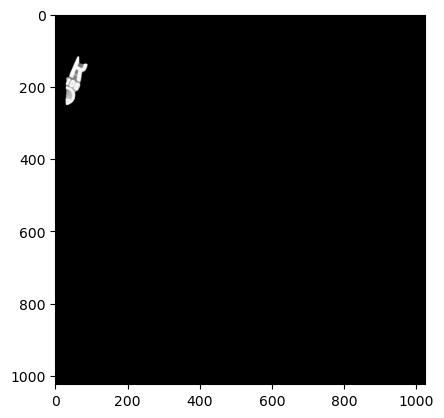

0.9448437690734863


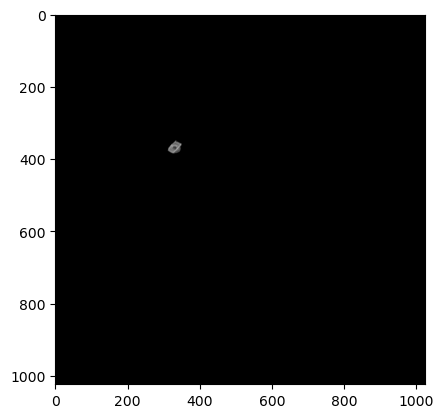

0.944305956363678


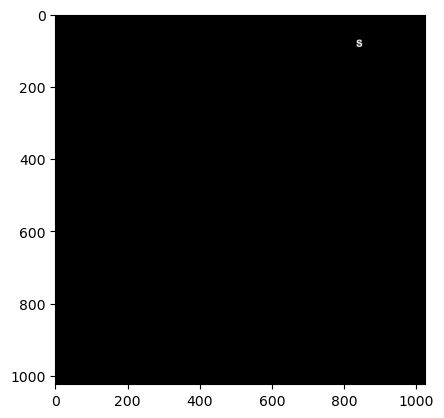

0.943930447101593


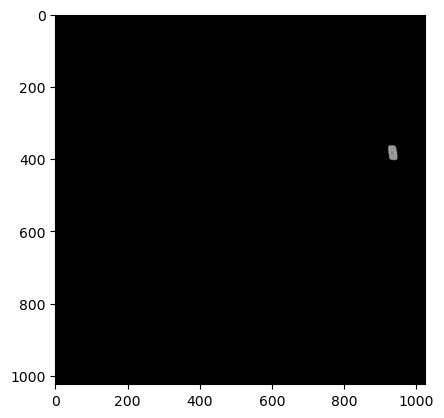

0.9437233805656433


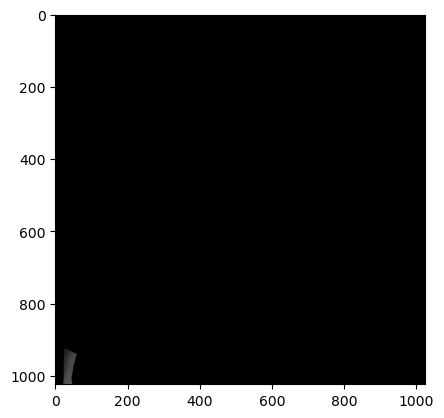

0.9411473274230957


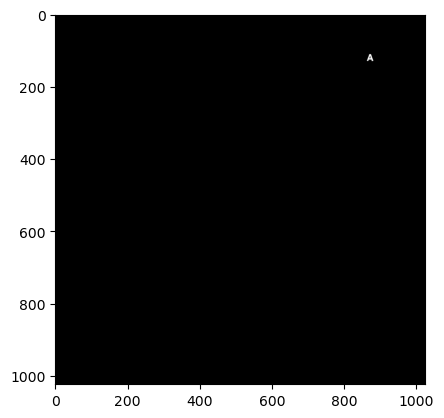

0.9407262206077576


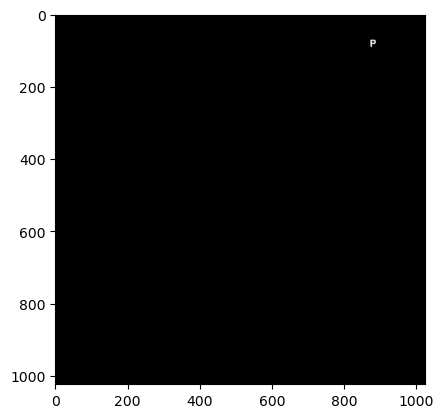

0.9368167519569397


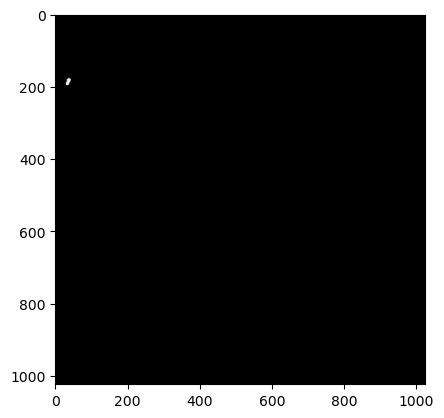

0.9357057213783264


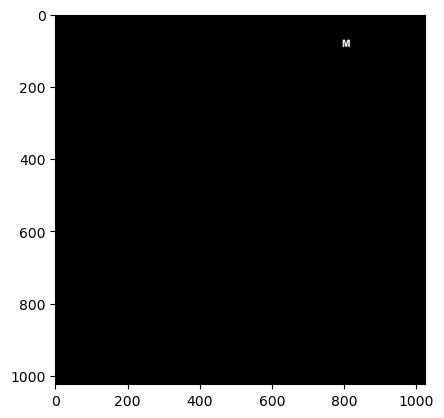

0.9338688850402832


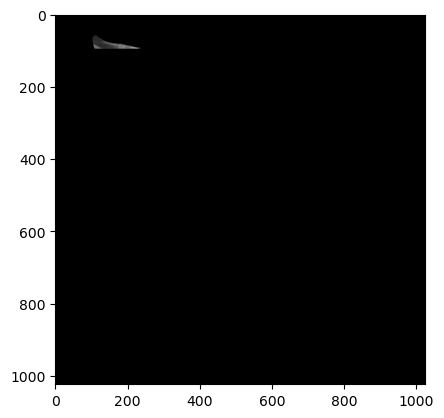

0.9316776990890503


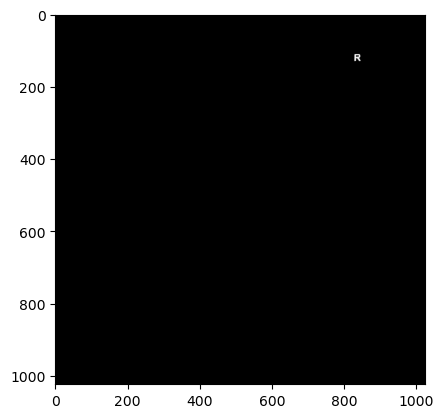

0.9308540225028992


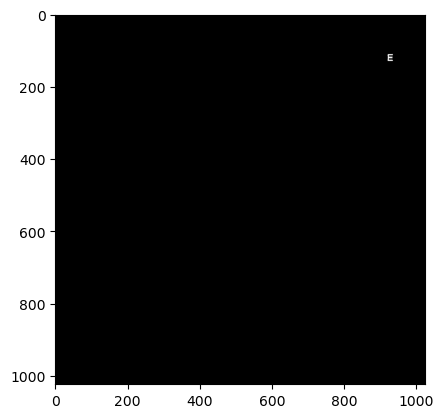

0.9302655458450317


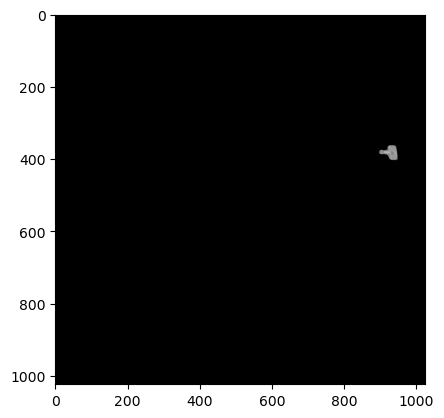

0.9297254085540771


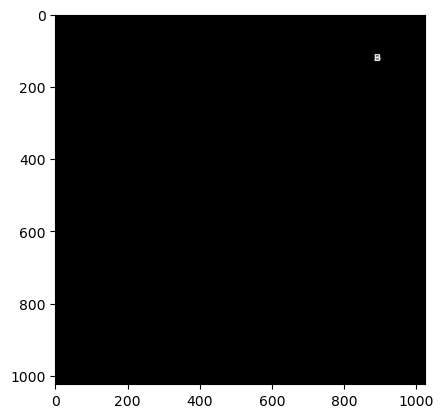

0.9293771982192993


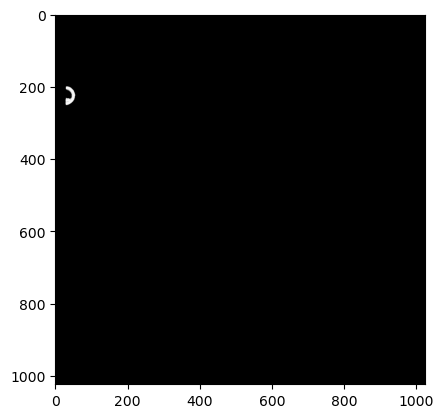

0.9284731149673462


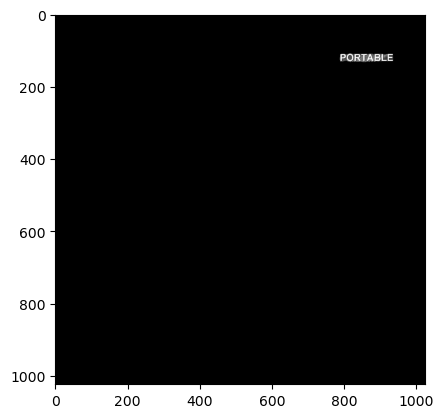

0.9267421364784241


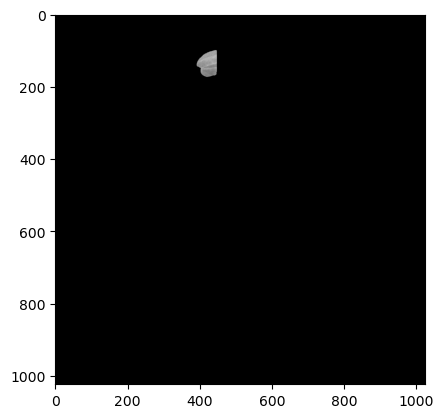

0.9233212471008301


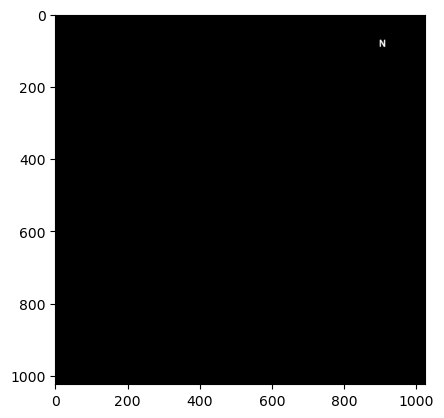

0.9220567941665649


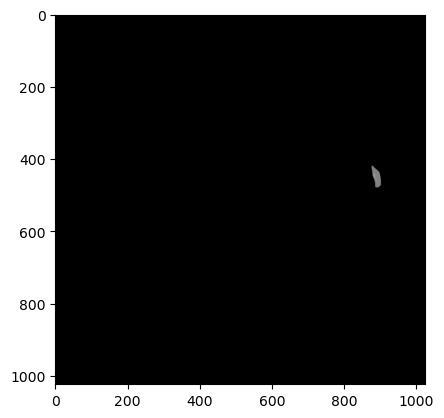

0.9209195375442505


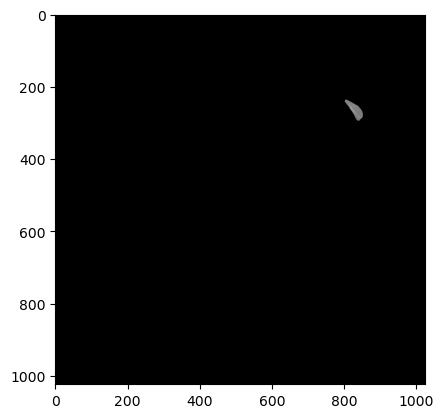

0.9206780791282654


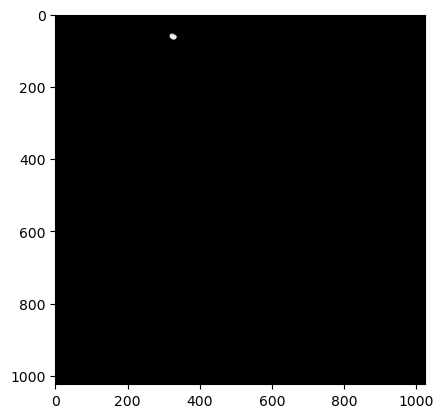

0.9203659892082214


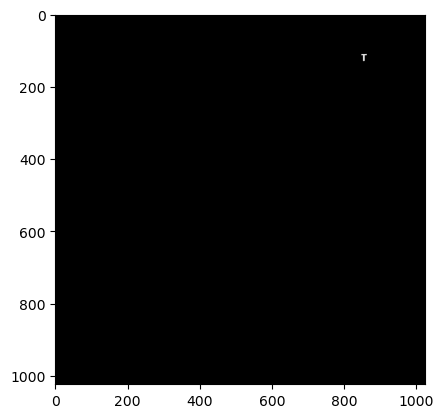

0.9193750619888306


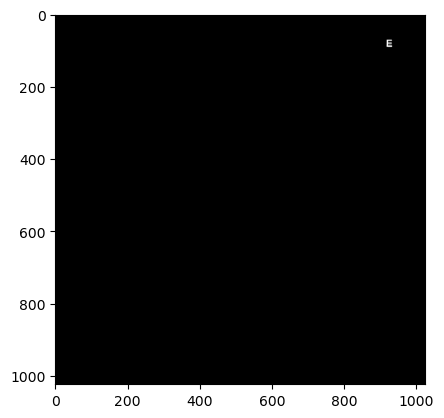

0.9188074469566345


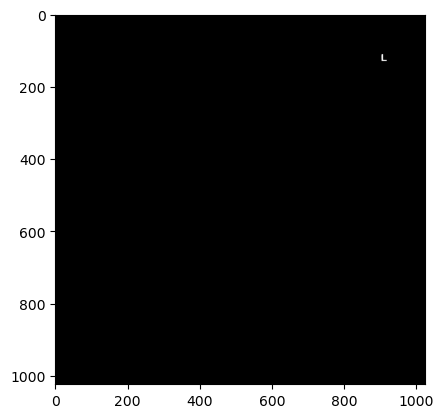

0.9137261509895325


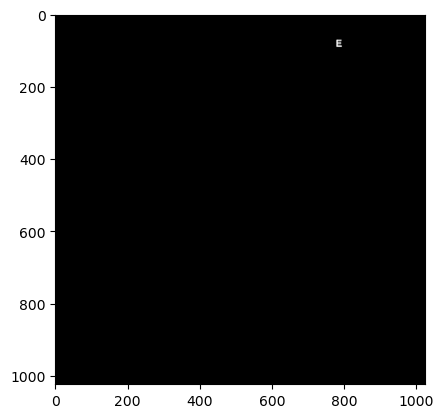

0.9133309721946716


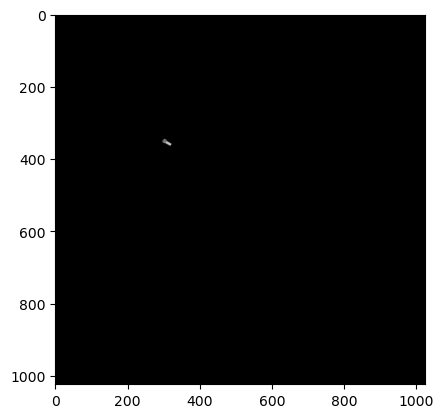

0.9127556085586548


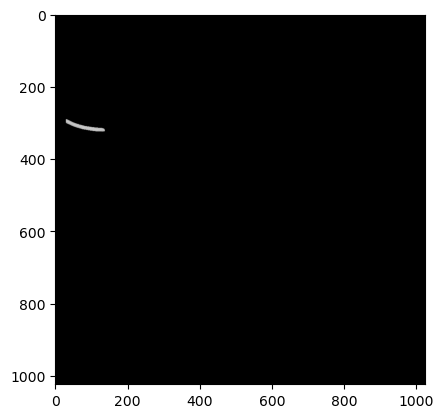

0.9123029112815857


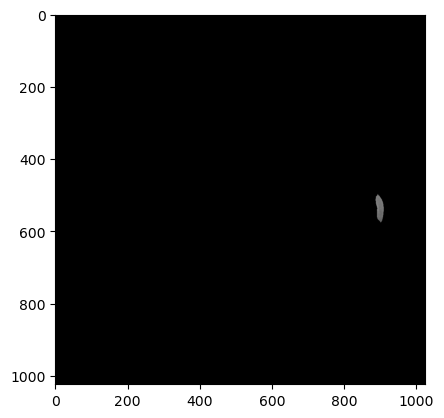

0.9047529101371765


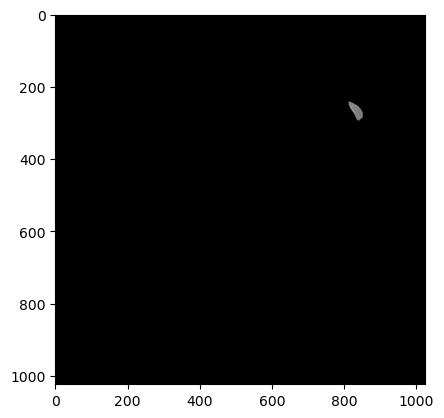

0.9041523933410645


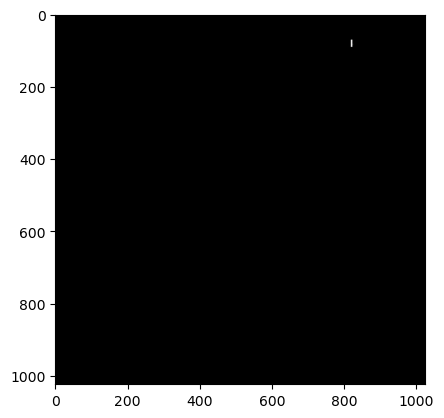

0.9024104475975037


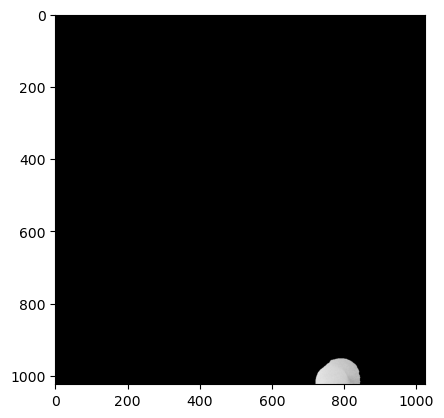

0.8965730667114258


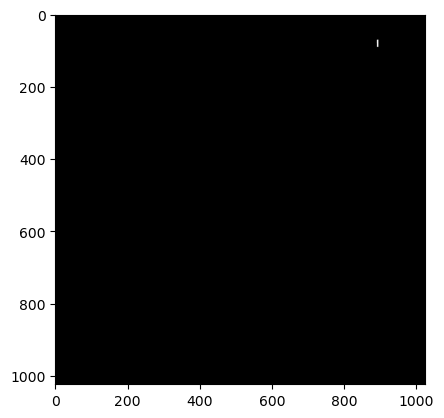

0.8873418569564819


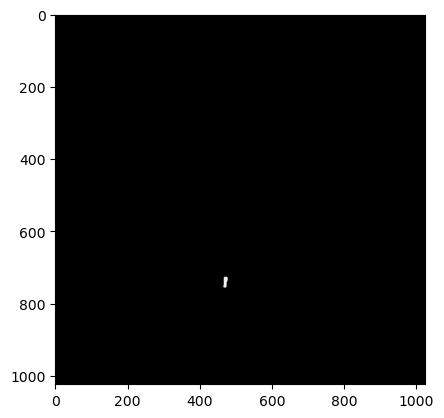

0.9975003004074097


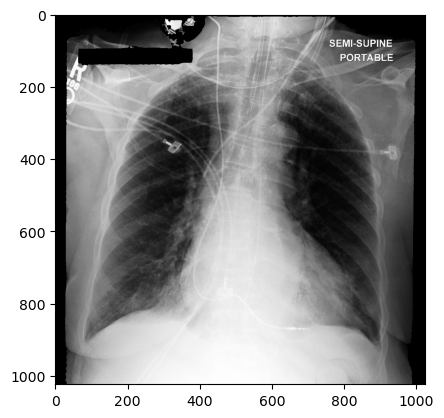

0.9595163464546204


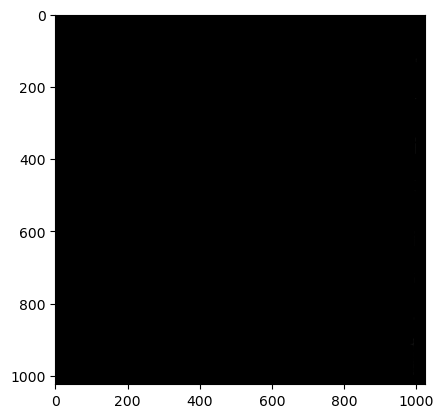

0.9343171715736389


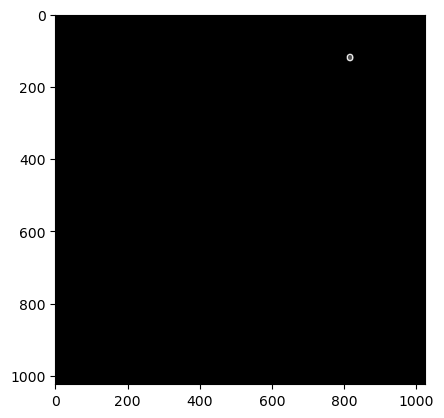

In [79]:
# list all of the segmentations 
for idx in range(len(sam_result)):
    print(sam_result[idx]['predicted_iou'])
    mask = np.repeat(sam_result[idx]['segmentation'][:, :, np.newaxis], 3, axis=2)
    img_copy = image_rgb.copy()
    img_copy[~mask] = 0
    plt.imshow(img_copy)
    plt.show()

# Autopipeline

In [146]:
# TODO: Need to update to store the img_path 
num_images = 5
max_sam_masks = 10

#loop through images, compute their mask
all_masks = {} #list of masks; all_masks[i] is a list of the masks for the ith image
embeds = [] #list of embeddings; embeds[i] is a list of the embeddings for the masked images from image i 
all_masked_imgs = {} #list of masked out images; all_masked_imgs[i] is a list of the masked images from image i
for i in tqdm(range(num_images)):
    embed_list = []
    masked_img_list = []
    p = img_dir + meta['img_path'].iloc[i]
    img = cv2.imread(p)
    image_rgb = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    np_image = np.array(image_rgb)
    
    sam_result = mask_generator.generate(image_rgb)

    max_masks = min(max_sam_masks, len(sam_result))
    masks = [sam_result[j]['segmentation'] for j in range(max_masks)]
    all_masks[p] = masks

    #loop through the masks
    for _mask in masks:
        masked_image = np_image * _mask[:, :, np.newaxis] #mask out the image for the th image
        
        #embed the masked image
        inputs = processor(images=[masked_image], return_tensors="pt").to('cpu') 
        image_features = model.get_image_features(**inputs).detach().to('cpu').numpy()
        embed_list.append(image_features)
        masked_img_list.append(masked_image)
        
    all_masked_imgs[p] = masked_img_list
    embeds.append(embed_list)

100%|███████████████████████████████████████████████████████| 5/5 [01:50<00:00, 22.09s/it]


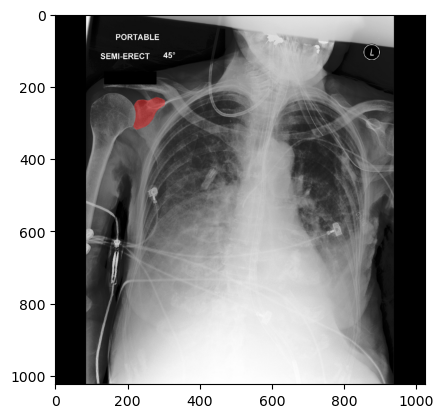

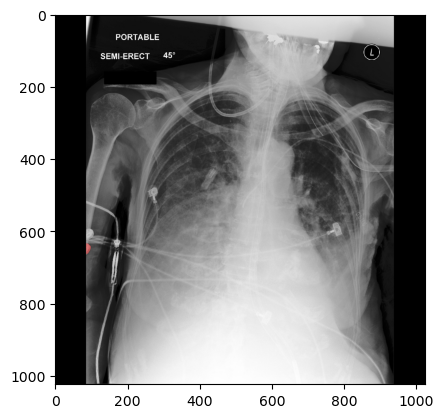

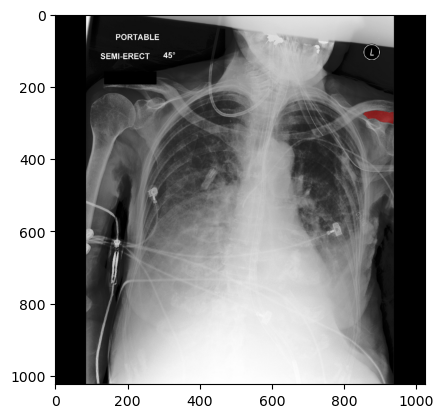

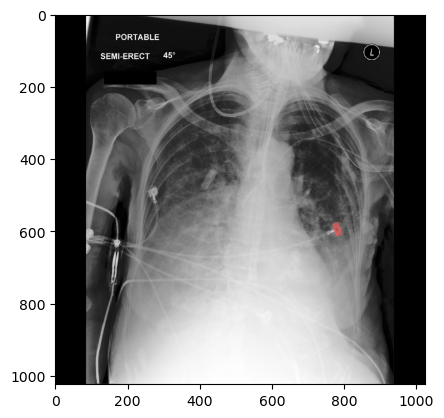

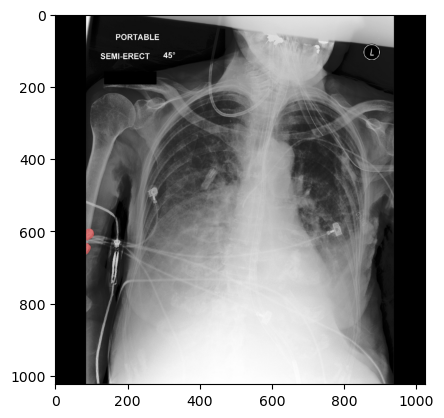

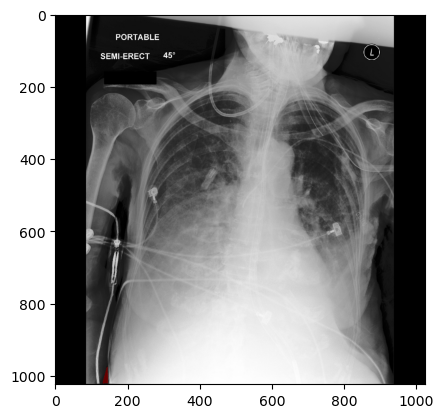

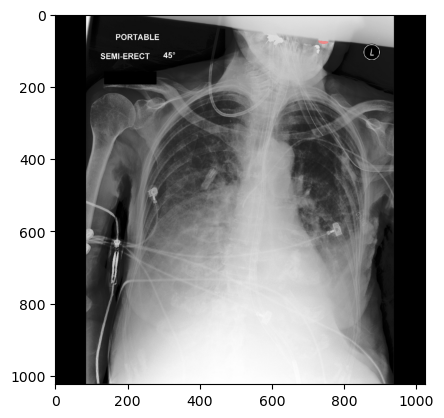

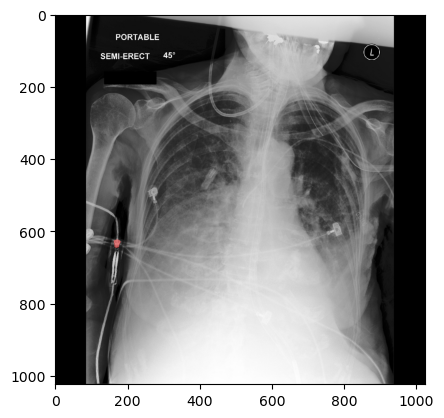

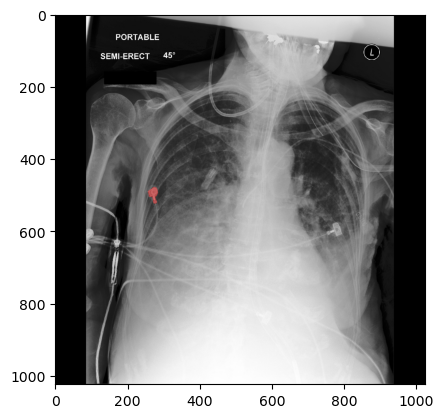

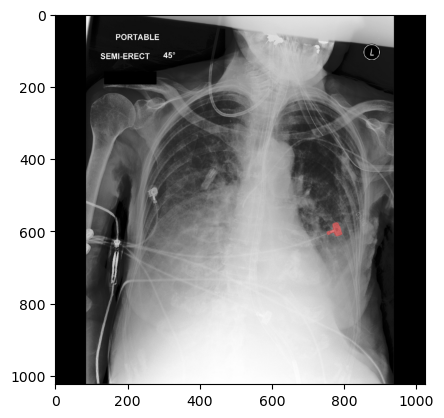

In [138]:
for _mask in masks[15:25]: 
    plt.figure()
    plt.imshow(np_image * _mask[:, :, np.newaxis])
    mask_inv = np.invert(_mask)
    np_image_copy = np_image.copy()
    np_image_copy[mask_inv] = [255, 255, 255]
    plt.figure()
    plt.imshow(np_image_copy)
    plt.show()

    colored_img = np_image.copy()
    colored_img[_mask] = [255, 0, 0]
    annotated_img = cv2.addWeighted(np_image, 0.6, colored_img, 0.4,0)
    plt.figure()
    plt.imshow(annotated_img)

In [147]:
agg_logits = np.concatenate(tuple(embeds)).squeeze()

In [148]:
agg_logits.shape

(50, 512)

In [150]:
# PCA for KMeans 
pca = PCA(n_components=32)
transformed_logits_cluster = pca.fit_transform(agg_logits)

In [ ]:
sil = []
potential_k = range(5, 16)
for k in potential_k: 
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(transformed_logits_cluster)
    labels = kmeans.labels_
    sil.append(silhouette_score(transformed_logits_cluster, labels, metric = 'euclidean'))

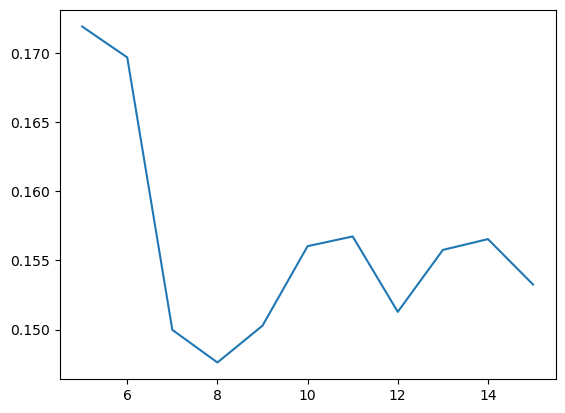

In [99]:
plt.plot(potential_k, sil)
plt.show()

In [151]:
# Set manually 
optimal_k = 15
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init="auto").fit(transformed_logits_cluster)
labels = kmeans.labels_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f739d0f5990>
Traceback (most recent call last):
  File "/data/healthy-ml/scratch/qixuanj/anaconda3/envs/spurious_imagenet/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/healthy-ml/scratch/qixuanj/anaconda3/envs/spurious_imagenet/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/healthy-ml/scratch/qixuanj/anaconda3/envs/spurious_imagenet/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/healthy-ml/scratch/qixuanj/anaconda3/envs/spurious_imagenet/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeEr

In [ ]:
grouped_masks = {}
for i in range(optimal_k): 
    grouped_masks[i] = []

counter = 0    
for mask_list in all_masked_imgs: 
    for value in mask_list:
        grouped_masks[labels[counter]].append(value)
        counter += 1

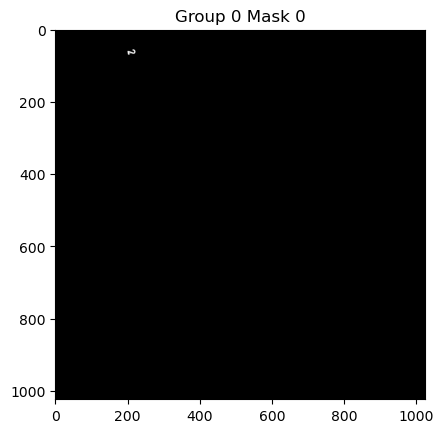

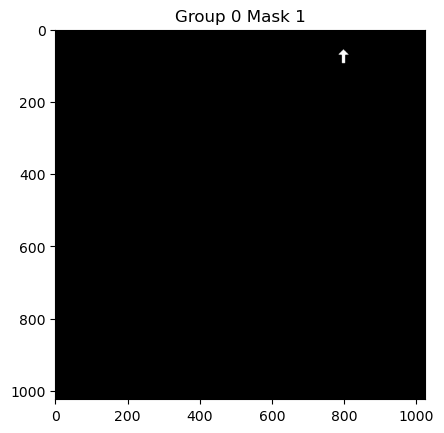

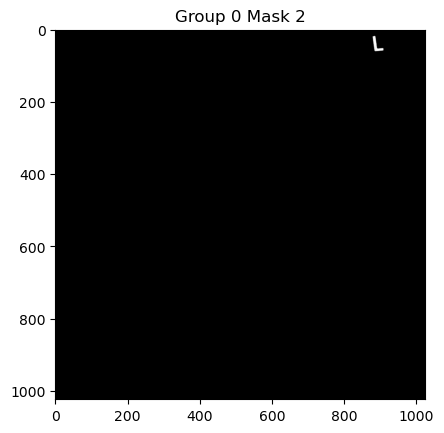

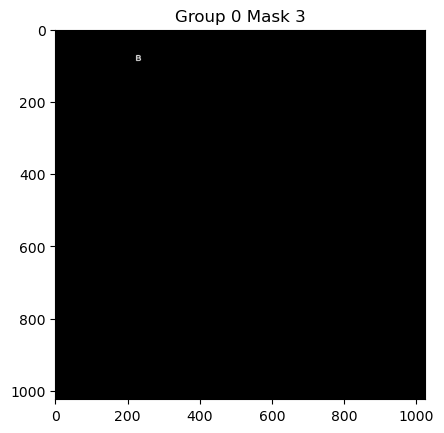

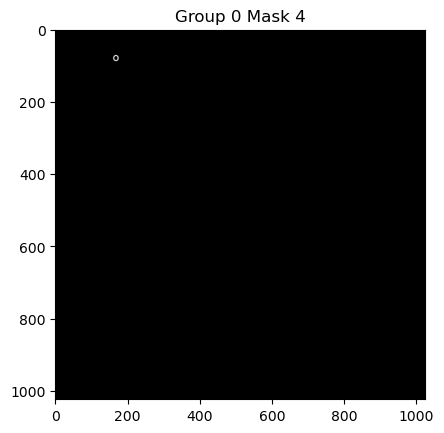

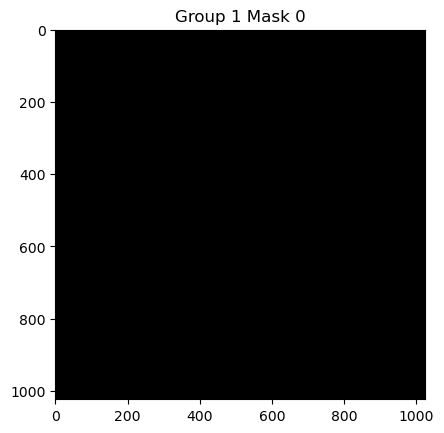

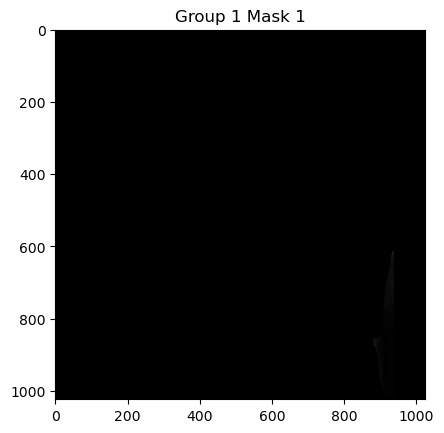

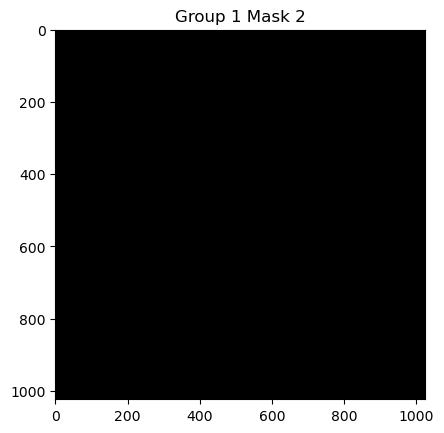

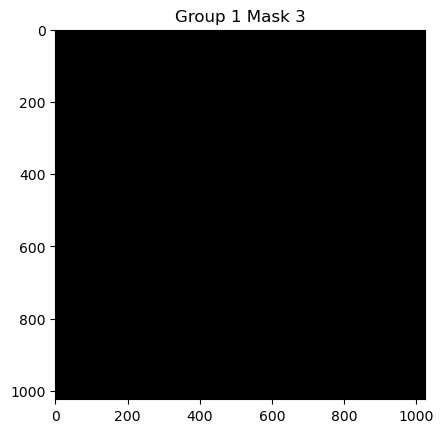

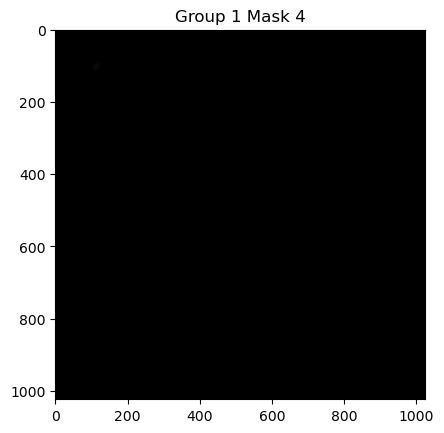

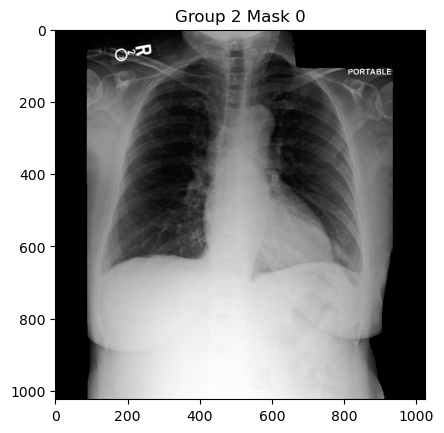

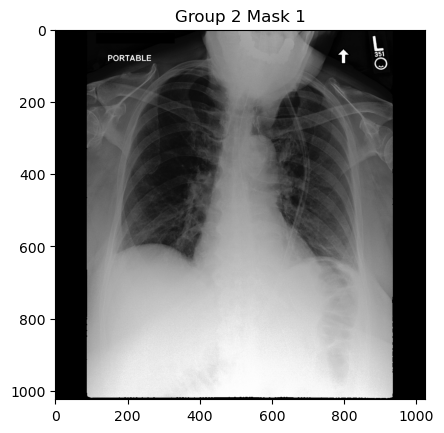

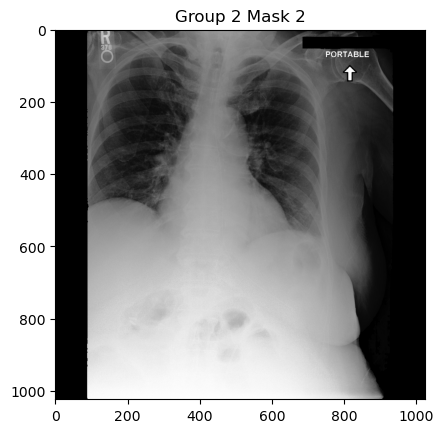

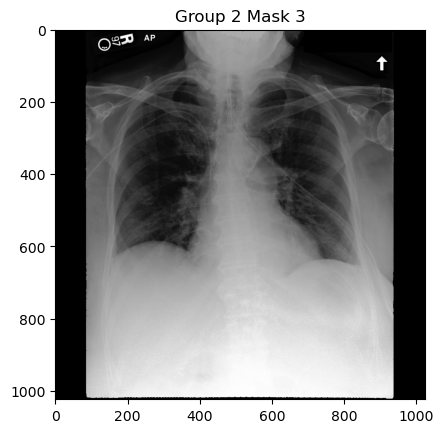

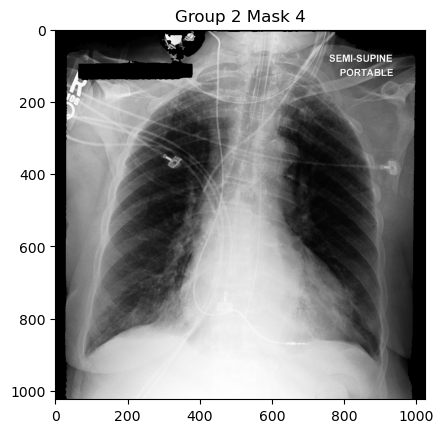

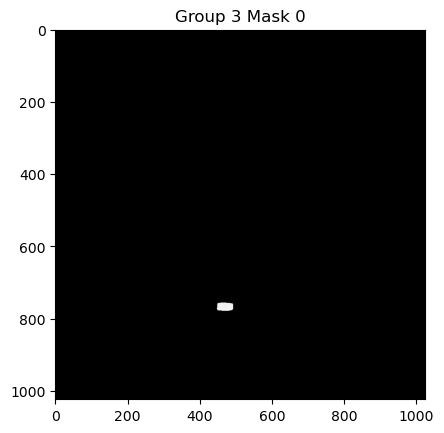

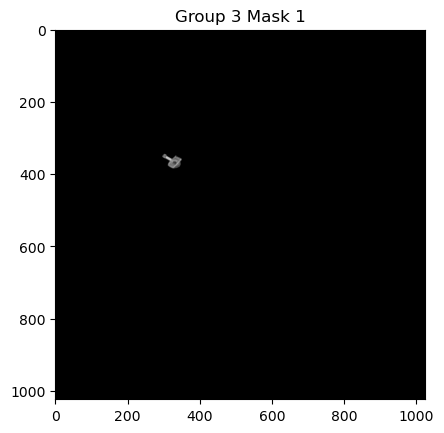

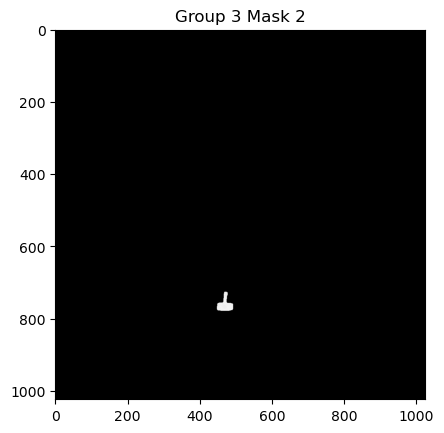

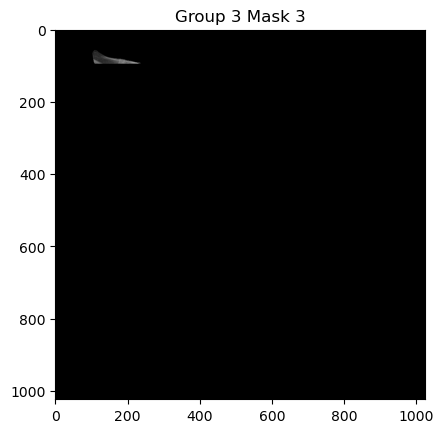

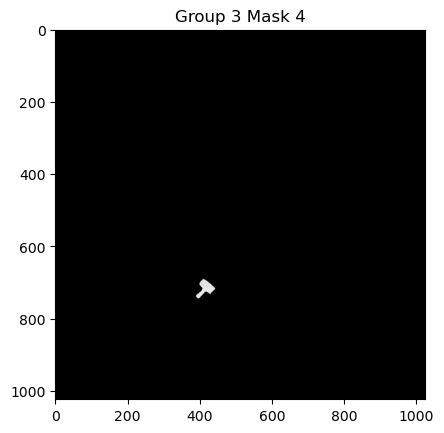

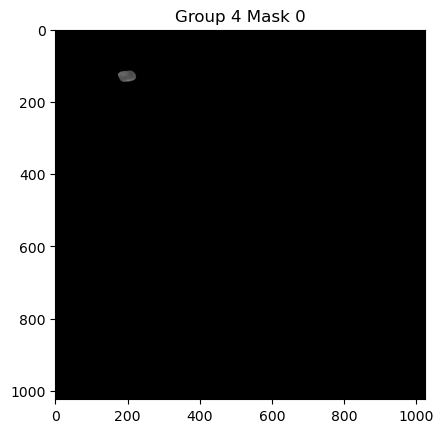

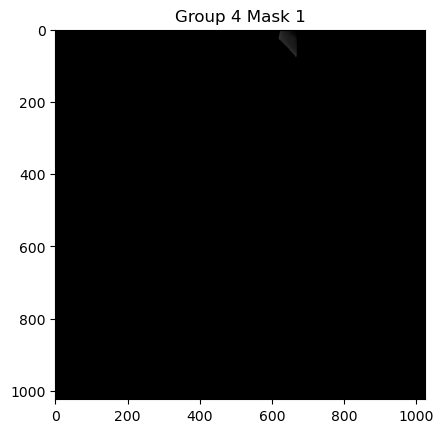

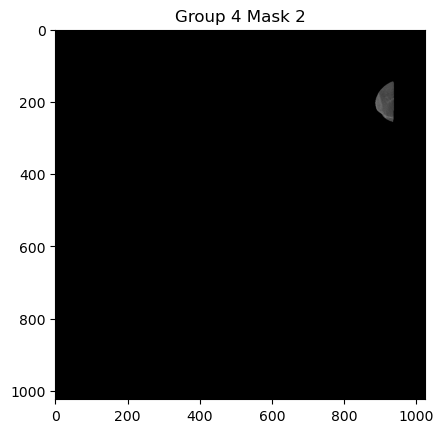

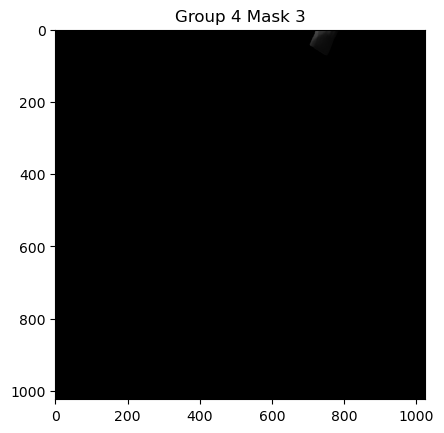

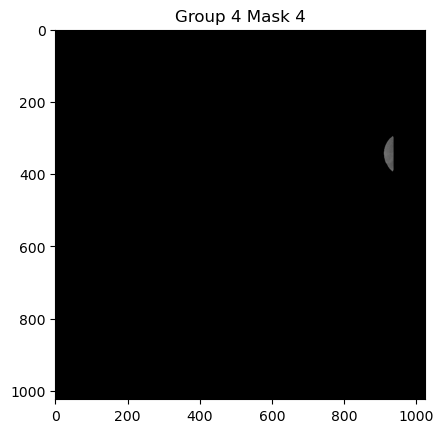

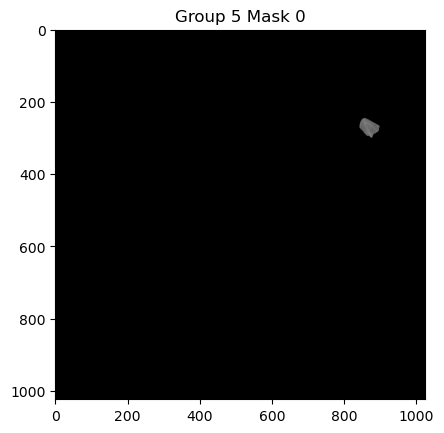

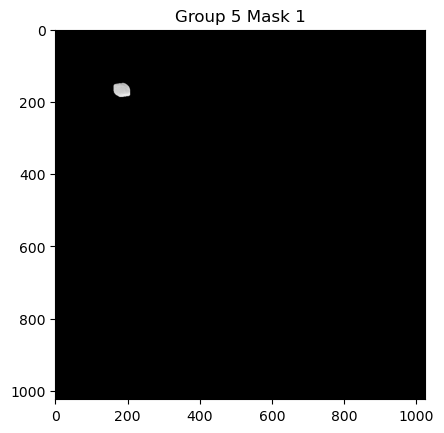

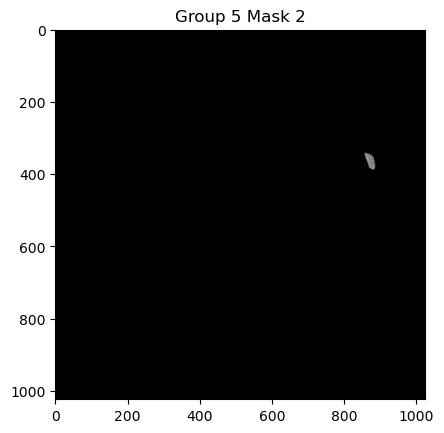

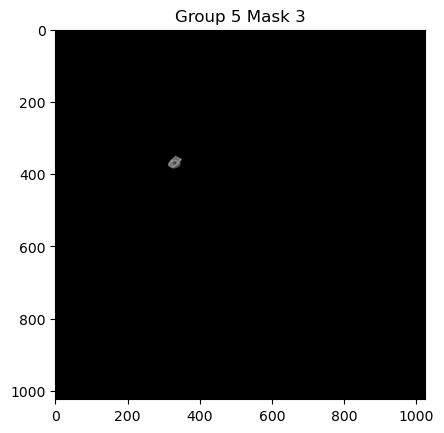

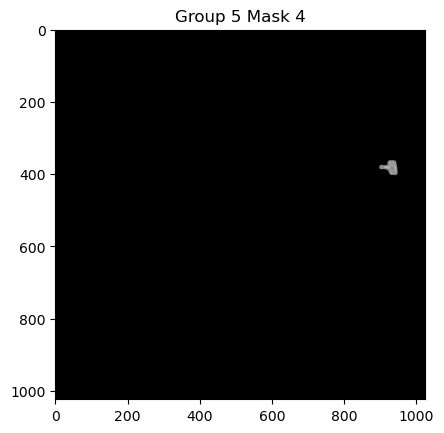

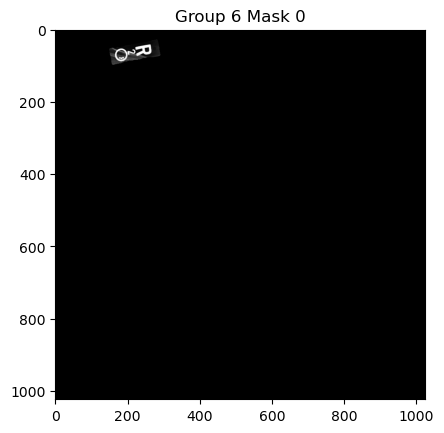

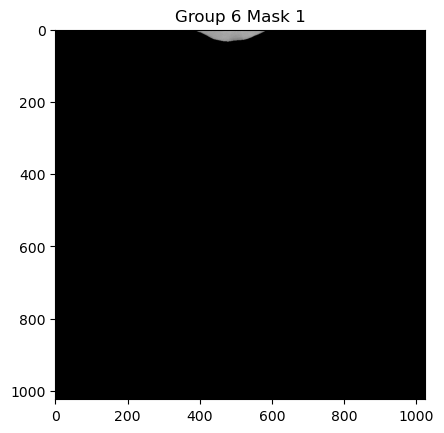

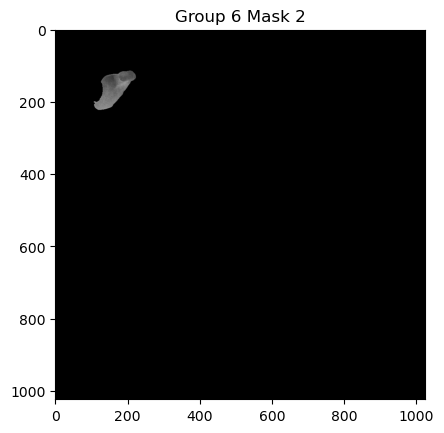

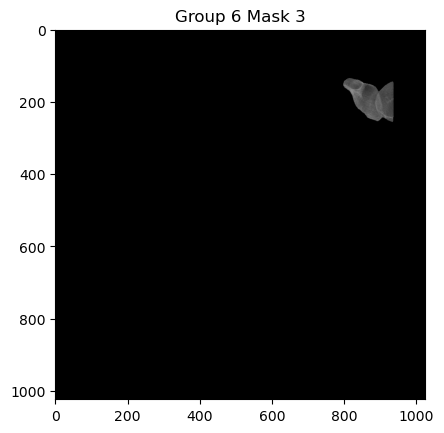

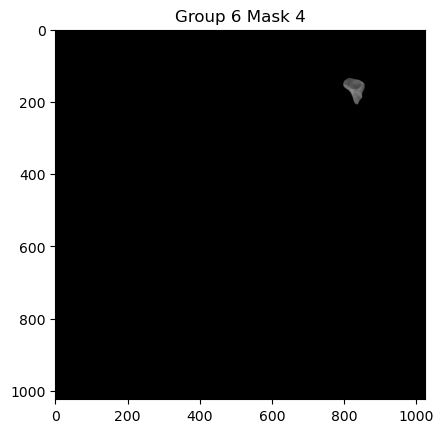

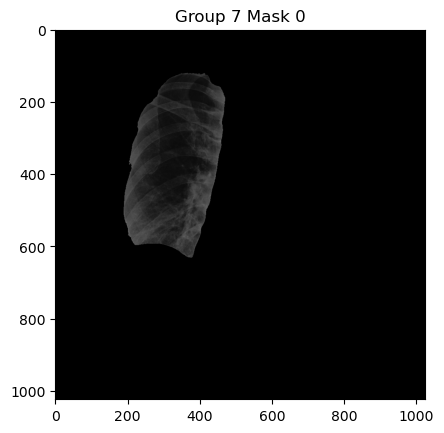

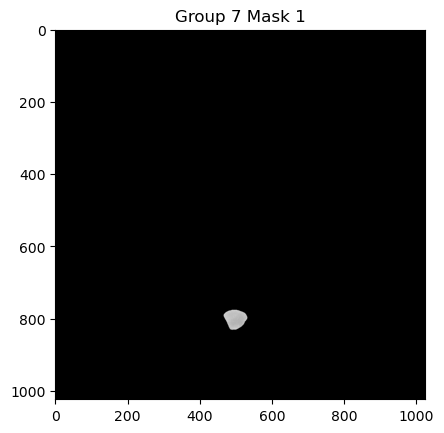

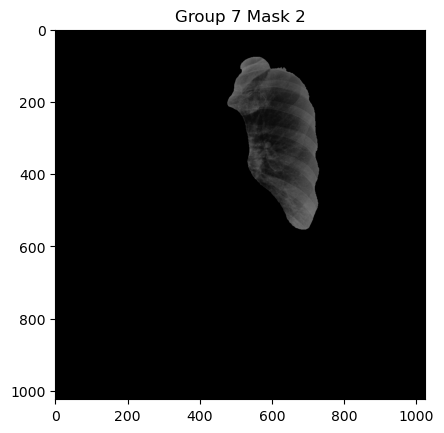

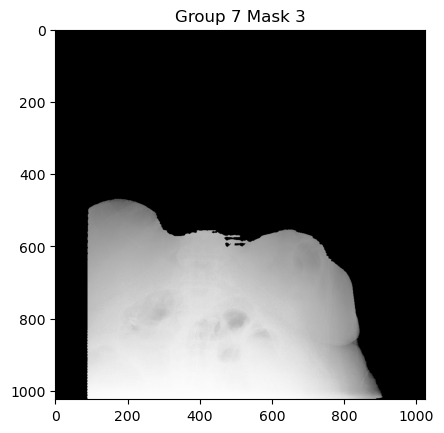

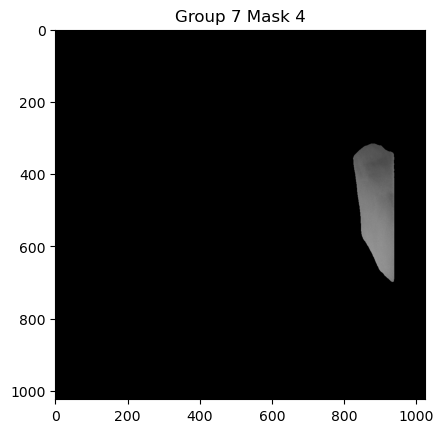

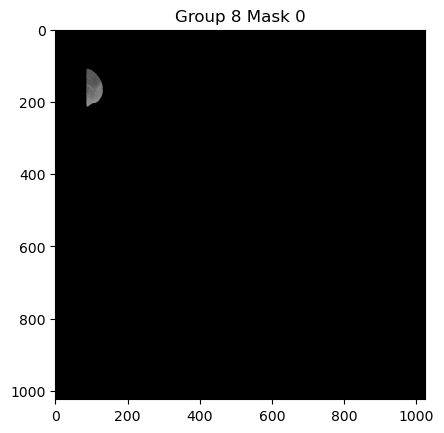

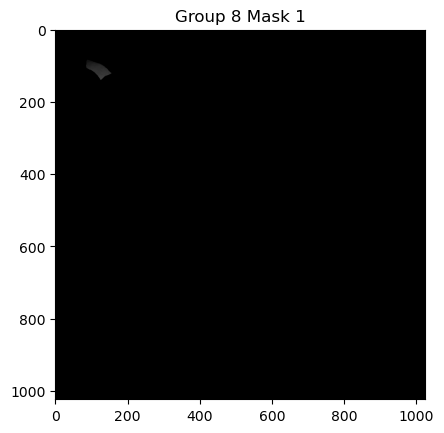

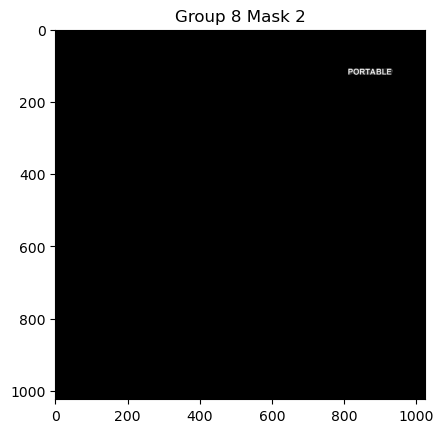

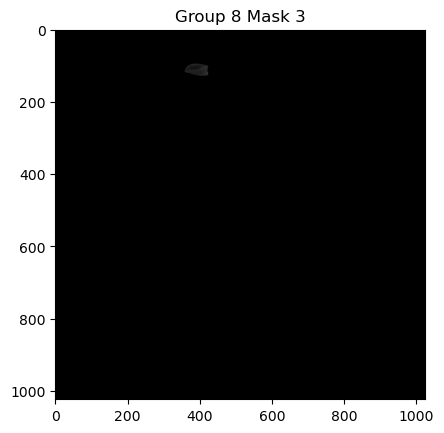

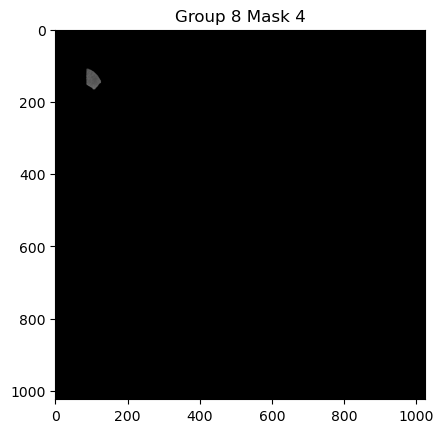

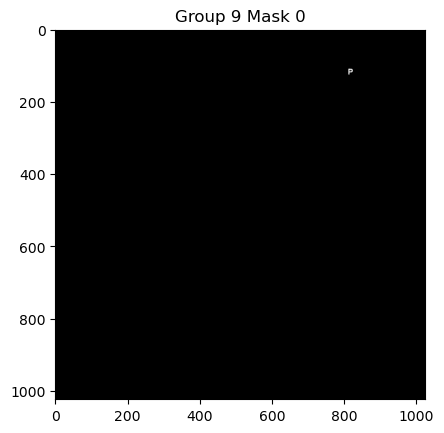

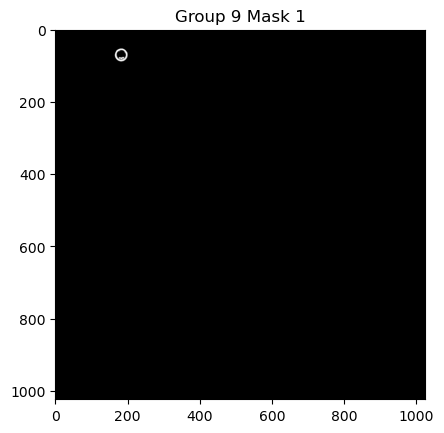

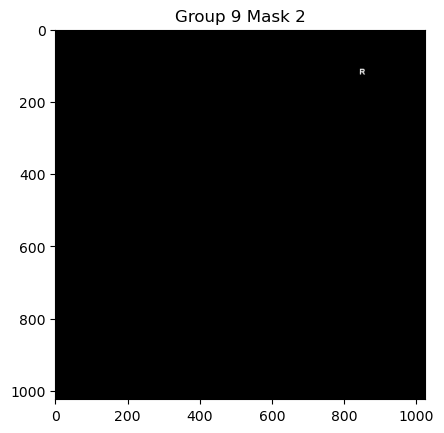

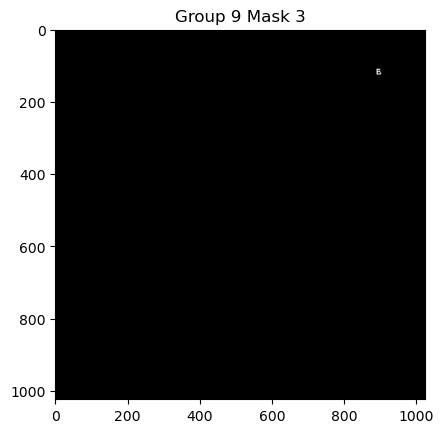

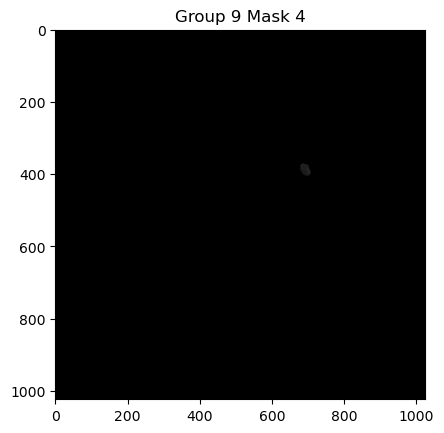

In [110]:
for i, mask_list in grouped_masks.items(): 
    for j in range(min(len(mask_list), 5)):
        mask_copy = mask_list[j].copy()
        plt.figure()
        plt.title(f"Group {i} Mask {j}")
        plt.imshow(mask_copy)
        plt.show()

In [152]:
grouped_masks = {}
for i in range(optimal_k): 
    grouped_masks[i] = [[], []]

counter = 0    
for path, mask_list in all_masks.items(): 
    for value in mask_list:
        grouped_masks[labels[counter]][0].append(path)
        grouped_masks[labels[counter]][1].append(value)
        counter += 1

In [154]:
grouped_masks

{0: [['/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/p10/p10001217/s58913004/5e54fc9c-37c49834-9ac3b915-55811712-9d959d26.jpg',
   '/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/p10/p10001217/s58913004/5e54fc9c-37c49834-9ac3b915-55811712-9d959d26.jpg',
   '/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/p10/p10001401/s50225296/0009a9fb-eb905e90-824cad7c-16d40468-007f0038.jpg',
   '/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/p10/p10001401/s56534136/d69651ae-dc7bacca-a05efc02-1d5882cd-001c77c4.jpg',
   '/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/p10/p10001401/s57492692/a83c7ff9-2d42639c-6ddebd0e-6b67809b-38210026.jpg',
   '/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/p10/p10001884/s50376803/469d0d94-3dad5068-efac76ef-a28cc502-68fe6275.jpg',
   '/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/p10/p10001884/s50376803/469d0d94-3dad5068-efac76ef-a28cc5

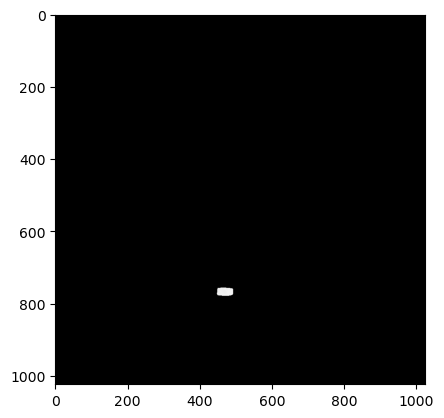

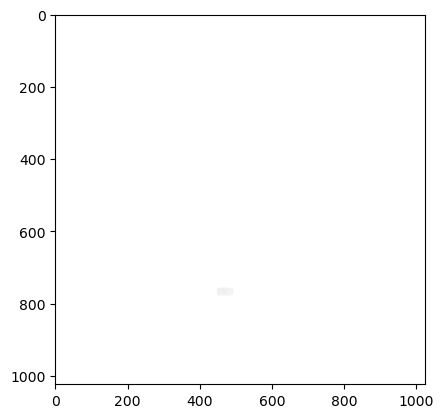

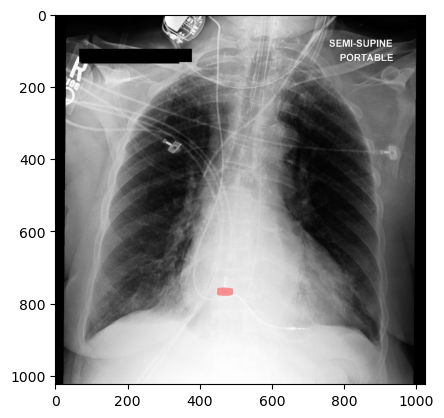

In [156]:
i = 0
for j in range(len(grouped_masks[i][0])): 
    img = cv2.imread(p)
    image_rgb = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    np_image = np.array(image_rgb)
    
    plt.figure()
    plt.imshow(np_image * _mask[:, :, np.newaxis])
    
    mask_inv = np.invert(_mask)
    np_image_copy = np_image.copy()
    np_image_copy[mask_inv] = [255, 255, 255]
    
    plt.figure()
    plt.imshow(np_image_copy)
    plt.show()

    colored_img = np_image.copy()
    colored_img[_mask] = [255, 0, 0]
    annotated_img = cv2.addWeighted(np_image, 0.6, colored_img, 0.4,0)
    plt.figure()
    plt.imshow(annotated_img)
    break

In [158]:
grouped_masks[i][0][j]

'/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/p10/p10001217/s58913004/5e54fc9c-37c49834-9ac3b915-55811712-9d959d26.jpg'

In [161]:
partition = grouped_masks[i][0][j].split("/")[-3]
study = grouped_masks[i][0][j].split("/")[-2]
img_id = grouped_masks[i][0][j].split("/")[-1].split(".")[0]

In [162]:
print(partition)
print(study)
print(img_id)

p10001217
s58913004
5e54fc9c-37c49834-9ac3b915-55811712-9d959d26


# Summarize grouped concepts and convert to segmentation masks 

In [5]:
dir = "/data/healthy-ml/scratch/qixuanj/generative_validation/sam_masks_mimic-cxr_annotated_fixed_copy"
subdirs = glob(dir + "/*/", recursive = True)

In [8]:
targetdirs = {}
feature_names = {}
init_tokens = {} 

count = 0
for s in subdirs:  
    feature_name = s.split("/")[-2].split("_")[0]
    init_token = s.split("/")[-2].split("_")[1]

    feature_names[count] = feature_name 
    init_tokens[count] = init_token 
    targetdirs[count] = s 
    count += 1 

In [10]:
img_paths = {}
for i, s in targetdirs.items(): 
    imgs = glob(s + "*.jpg")
    print(feature_names[i])
    print(init_tokens[i])
    print(len(imgs))
    img_paths[s.split("/")[-2]] = imgs

margin-left
black
14
spine-wire
wire
18
brassier-clips
clips
0
PA-right
PA
0
R-whole
R
19
cather-tube
tube
18
erect-left
erect
1
symbols-left
symbols
0
margin-top
black
3
AP-right
AP
6
earrings
earring
5
black-band-top-right
black
0
metal-throat
metal
22
two-dots-bottom
dot
0
45-deg
45
0
circle-under-L
circle
11
margin-right
black
7
supine-right
supine
7
erect-right
erect
1
semi-erect-right
erect
9
supine-left
supine
4
circle-under-R
circle
9
R-circle
R
12
paperclip
paperclip
0
L-circle
L
56
up-arrow-left
arrow
17
AP-left
AP
6
up-arrow-right
arrow
28
device
device
4
chin
chin
20
semi-erect-left
erect
7
symbols-right
symbols
0
portable-left
portable
29
metal-leads
lead
52
double-round-pin
pin
2
wire-left-outside
wire
4
black-band-top-left
black
6
two-dots-top
dot
0
button
button
16
portable-right
portable
31
wire-right-outside
wire
7
L-whole
L
38
wire-left-inside
wire
2
R
R
22
teeth
teeth
0
pacemaker
pacemaker
17
margin-bottom
black
4
round-leads
round
52
white-band-bottom
white
1
metal

In [11]:
mask_conversion = {"L-whole_L": "black", 
                   "R-whole_R": "black", 
                   "L-circle_L": "white", 
                   "portable-left_portable": "black", 
                   "metal-leads_lead": "black", 
                   "pacemaker_pacemaker": "black",}

In [20]:
print(len(mask_imgs["pacemaker_pacemaker"]))

17


In [12]:
mask_imgs = {}

for s, mask_color in mask_conversion.items(): 
    mask_imgs[s] = []
    for img_path in img_paths[s]: 
        p = img_path.split("/")[-1]
        if mask_color == "black": 
            mask_img_path = glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch1-copy/sam_masks_mimic-cxr_black/*/{p}", recursive = True)
            mask_img_path += glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch2-copy/sam_masks_mimic-cxr_black/*/{p}", recursive = True)
        elif mask_color == "white": 
            mask_img_path = glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch1-copy/sam_masks_mimic-cxr_white/*/{p}", recursive = True)
            mask_img_path += glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch2-copy/sam_masks_mimic-cxr_white/*/{p}", recursive = True)
        assert(len(mask_img_path) > 0)
        mask_imgs[s].append(mask_img_path[0])

In [13]:
mask_imgs

{'L-whole_L': ['/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch1-copy/sam_masks_mimic-cxr_black/group8/mask88_p10003400_s55549081_d74edd6a-7b3a85fe-733bde07-d46f005c-3124091c.jpg',
  '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch1-copy/sam_masks_mimic-cxr_black/group1/mask112_p10003637_s57024735_f6119cd4-a5ef793e-db8543a2-f8d4a0e1-8c8aeb54.jpg',
  '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch1-copy/sam_masks_mimic-cxr_black/group10/mask256_p10010867_s52247560_a15741a8-87f22867-dd371951-7e978b03-4317abb3.jpg',
  '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch2-copy/sam_masks_mimic-cxr_black/group7/mask214_p10016084_s50755440_94c42403-c3555741-61a25b2f-46aa9100-a3ec2f14.jpg',
  '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch1-copy/sam_masks_mimic-cxr_black/group6/mask48_p10003400_s50100991_ed7dc3ef-9ed80b39-d9ae643a-964c37dc-87f

In [21]:
print(len(mask_imgs['pacemaker_pacemaker']))

17


In [14]:
import shutil

In [15]:
output_dir = "/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training"
if not os.path.exists(output_dir): 
    os.makedirs(output_dir)

In [16]:
for s, imgs in mask_imgs.items(): 
    savedir = output_dir + "/" + s + "/"
    if not os.path.exists(savedir): 
        os.makedirs(savedir)
    for img in imgs: 
        shutil.copyfile(img, savedir + img.split("/")[-1])

2


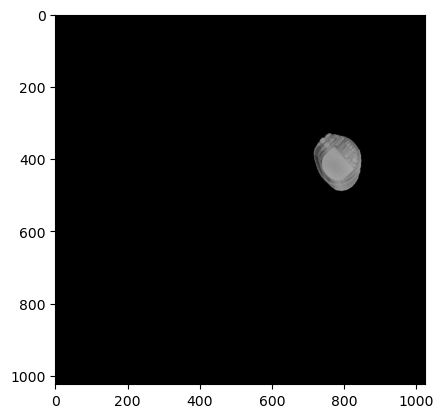

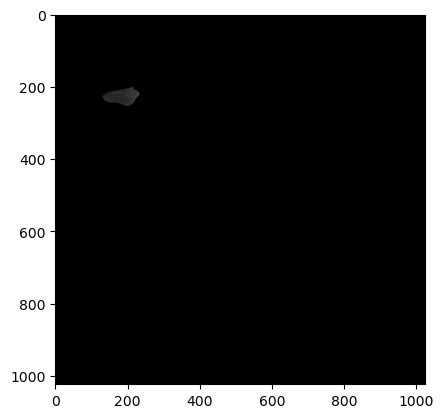

2


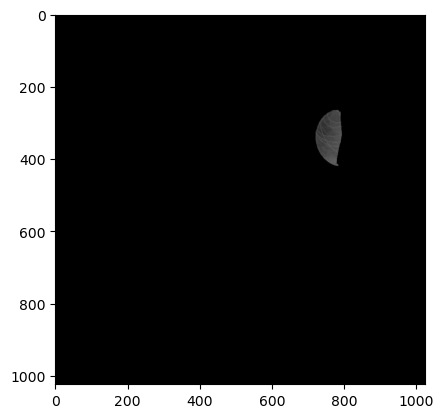

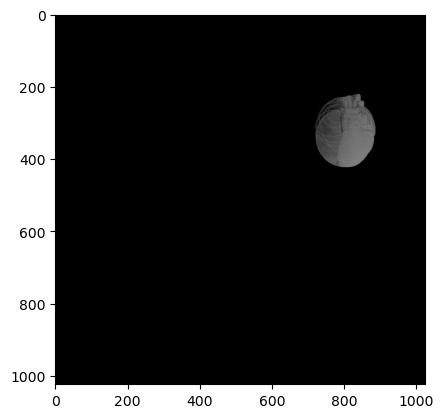

1


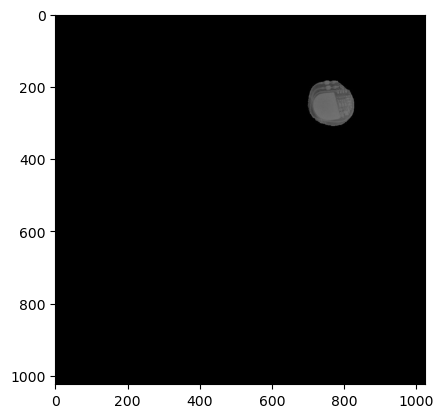

1


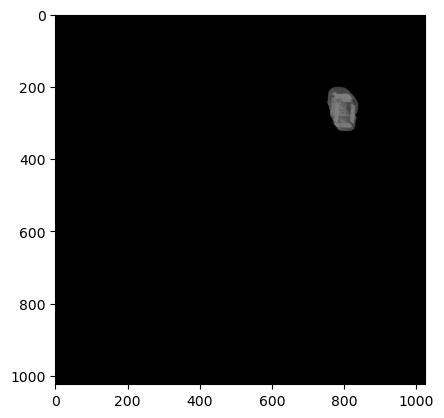

1


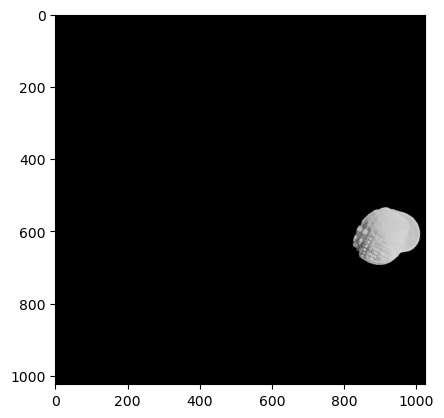

1


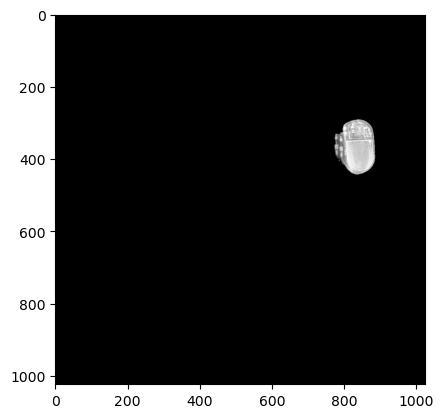

1


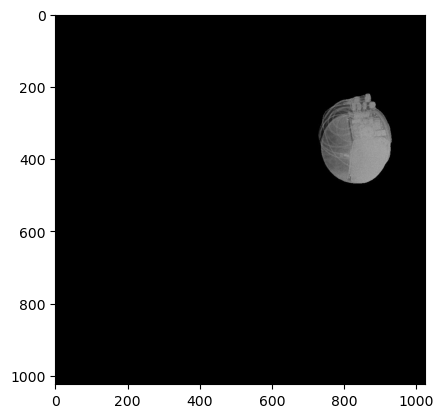

2


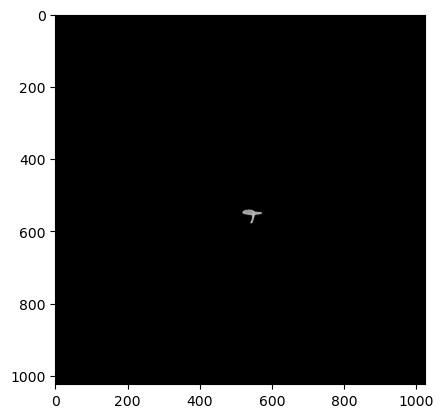

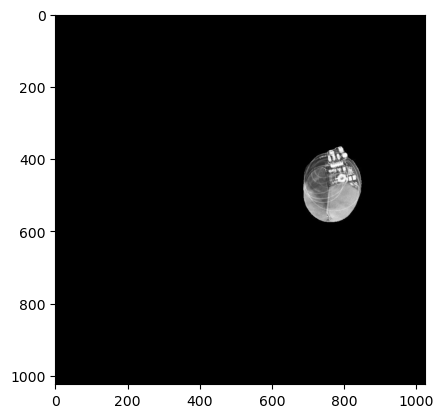

2


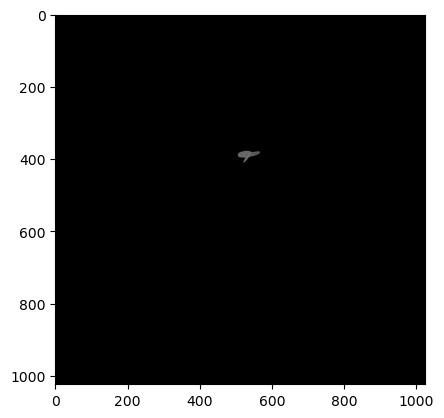

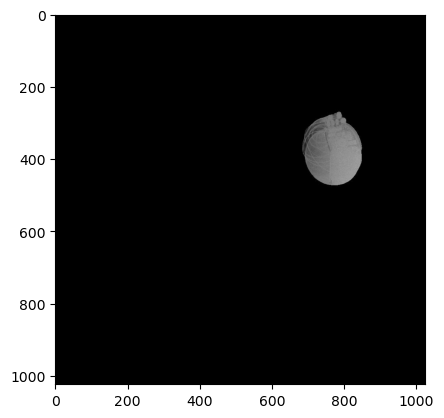

2


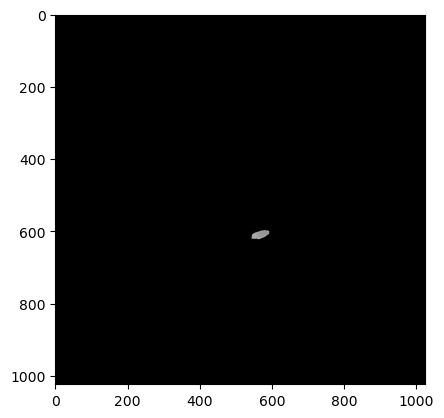

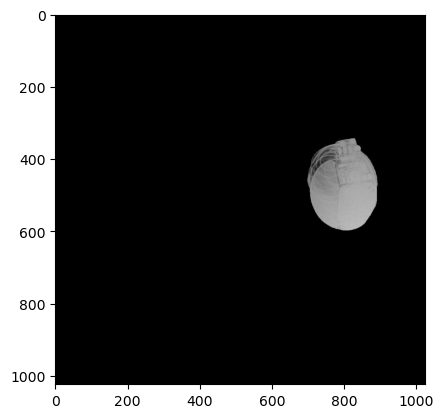

1


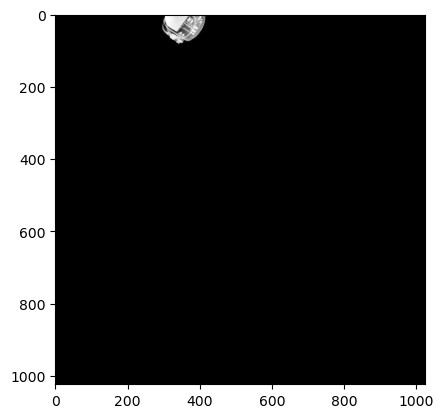

1


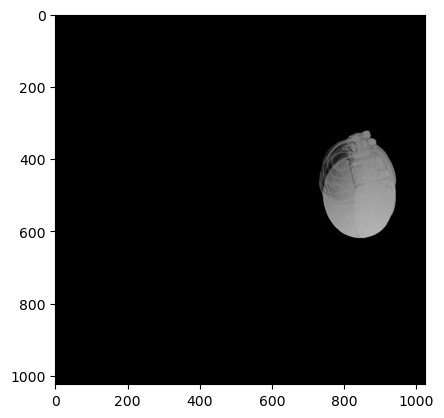

1


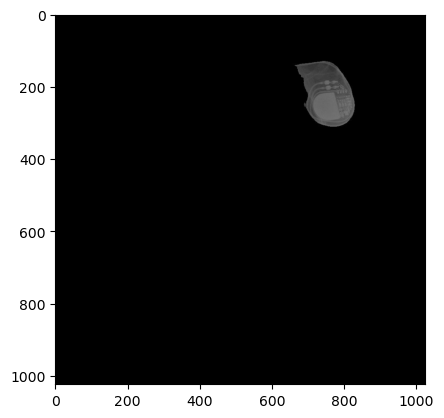

1


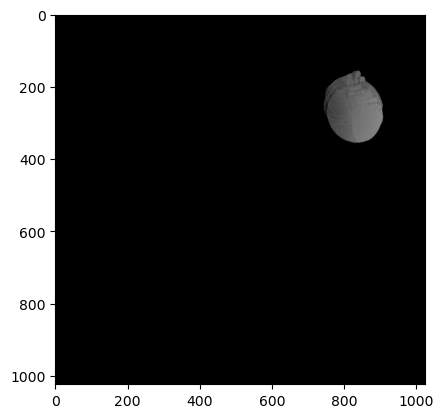

2


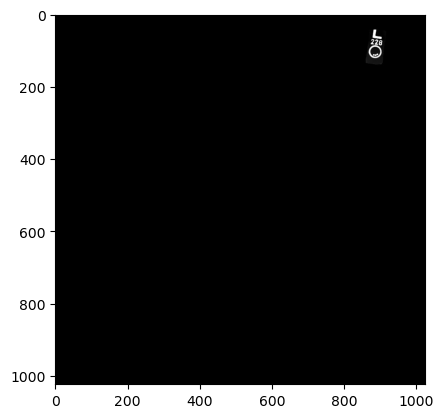

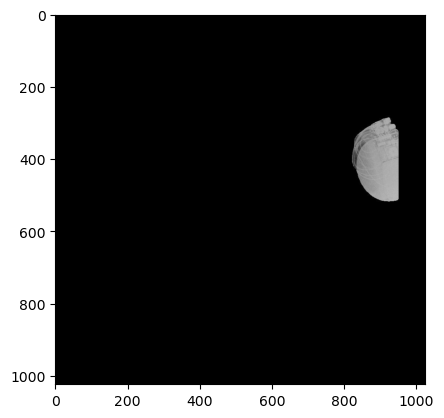

1


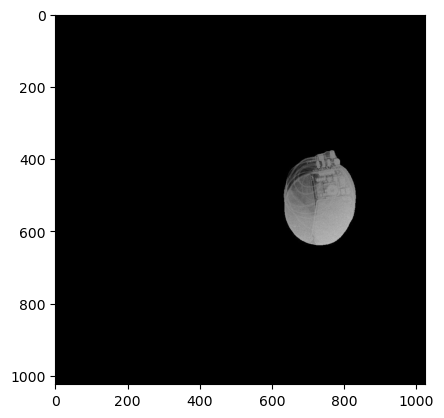

1


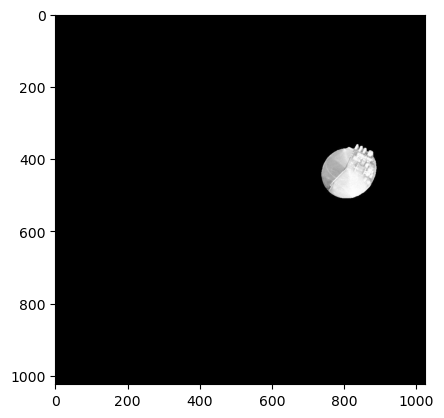

In [17]:
s = "pacemaker_pacemaker"
mask_color = "black"

for img_path in img_paths[s]: 
    p = img_path.split("/")[-1]
    if mask_color == "black": 
        mask_img_path = glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch1-copy/sam_masks_mimic-cxr_black/*/{p}", recursive = True)
        mask_img_path += glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch2-copy/sam_masks_mimic-cxr_black/*/{p}", recursive = True)
    elif mask_color == "white": 
        mask_img_path = glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch1-copy/sam_masks_mimic-cxr_white/*/{p}", recursive = True)
        mask_img_path += glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch2-copy/sam_masks_mimic-cxr_white/*/{p}", recursive = True)
    print(len(mask_img_path))
    for img_p in mask_img_path: 
        img = Image.open(img_p).convert("RGB")
        plt.imshow(img)
        plt.show()

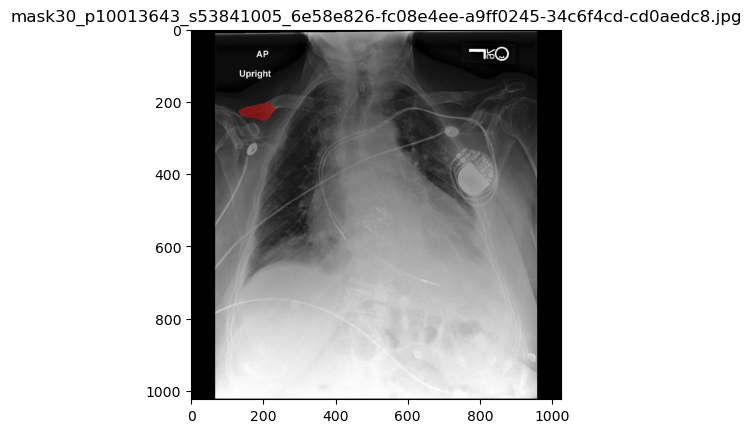

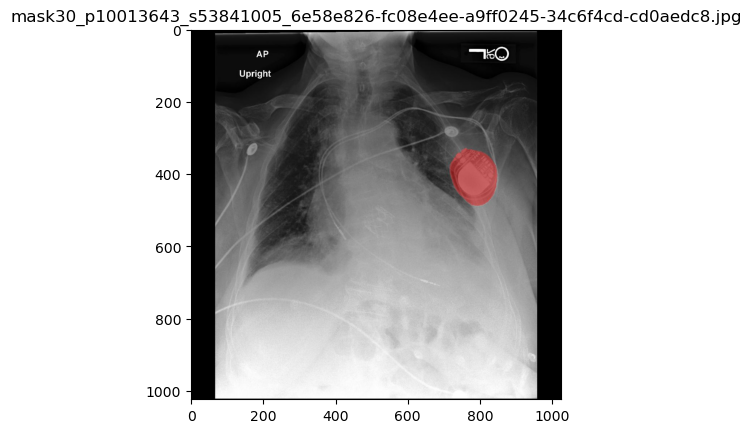

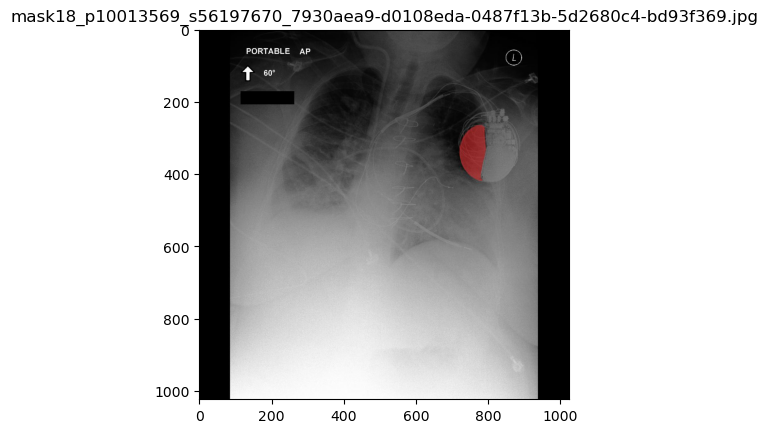

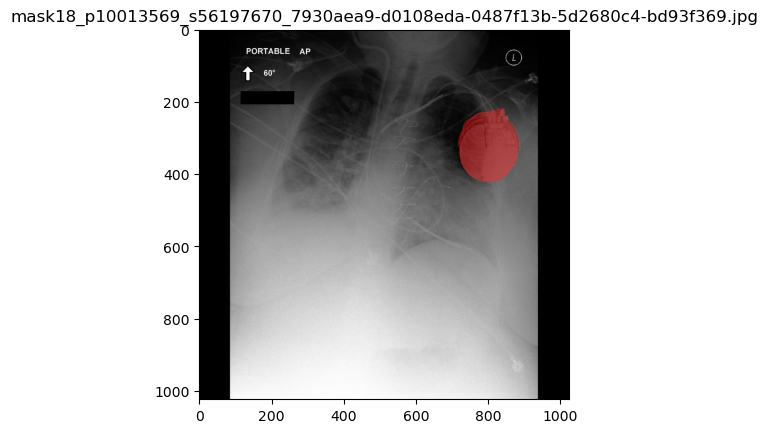

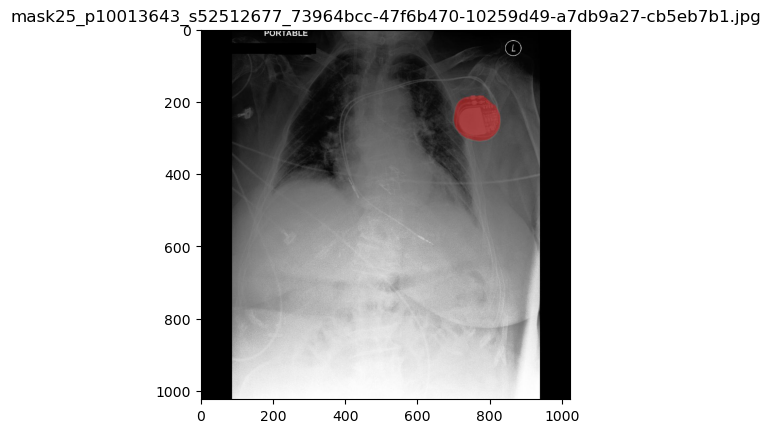

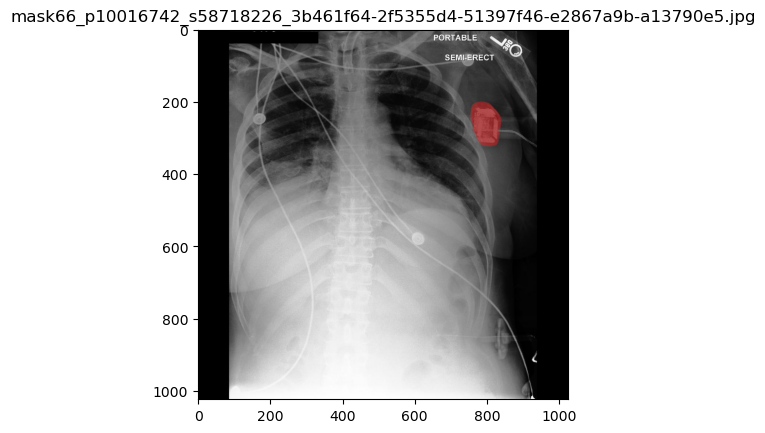

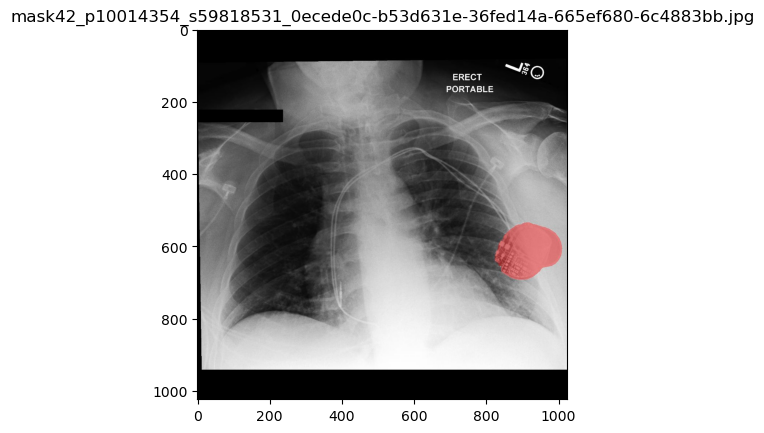

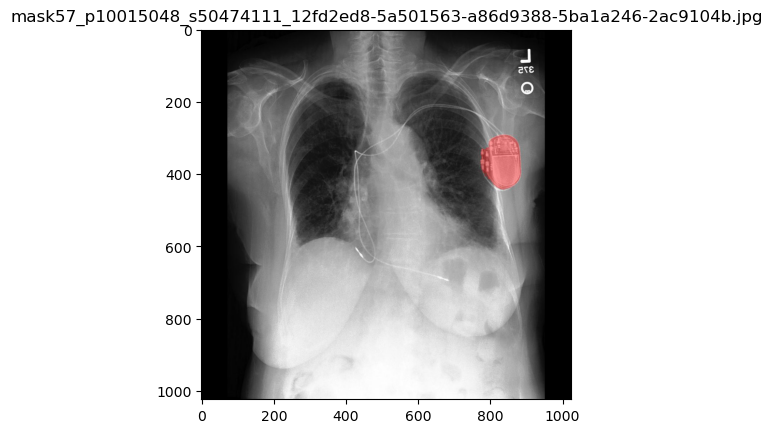

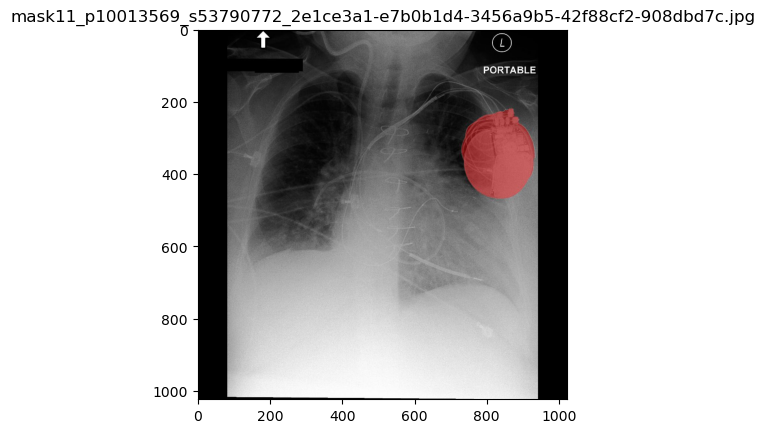

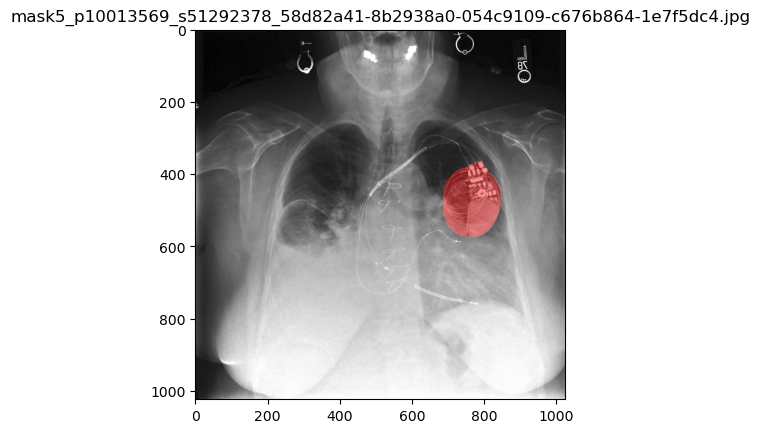

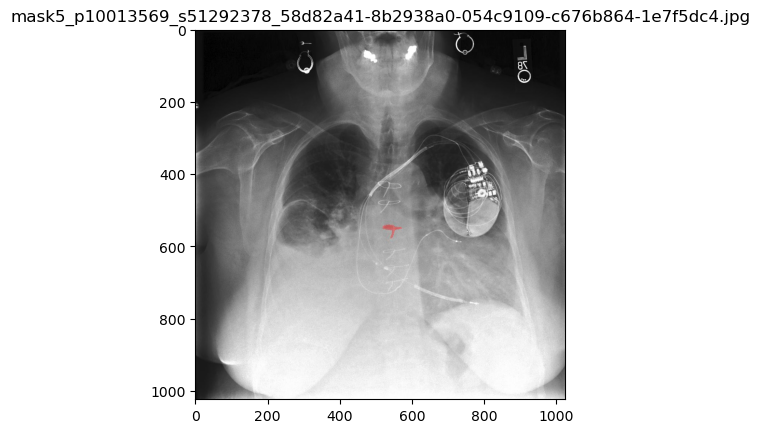

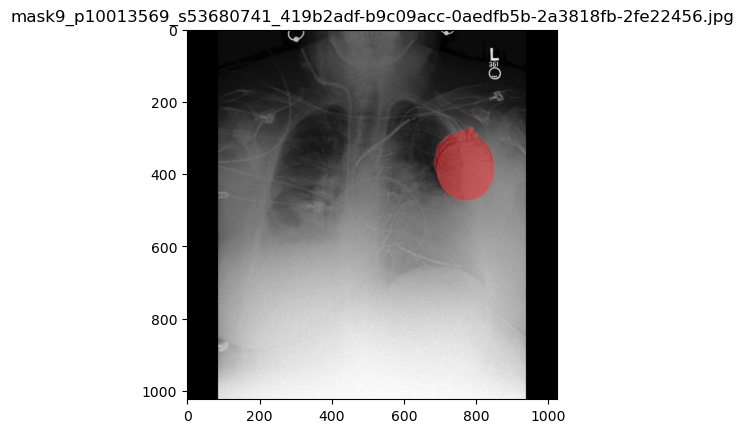

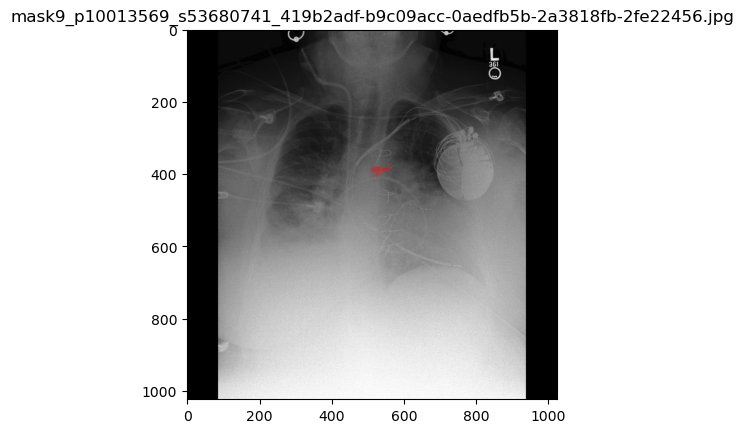

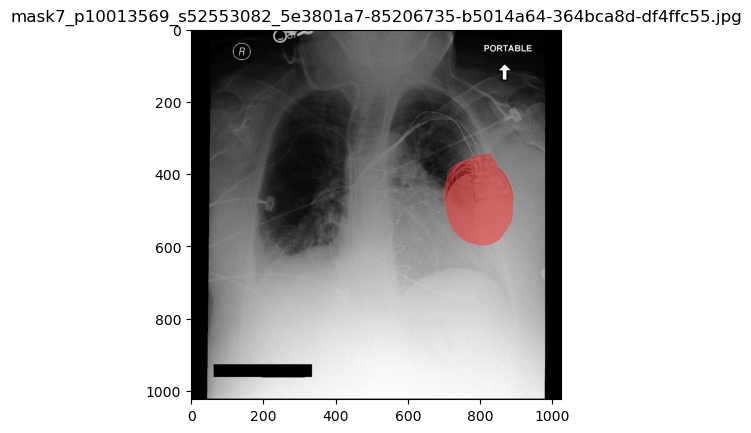

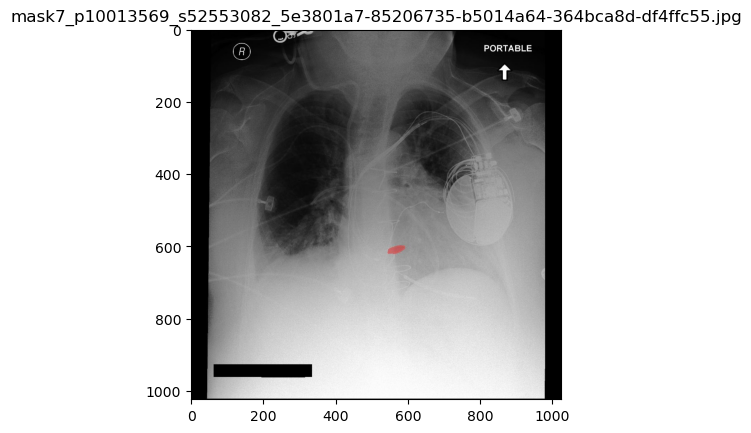

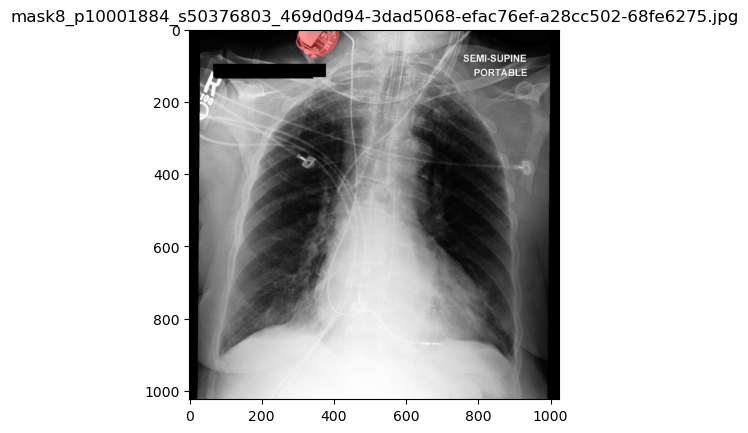

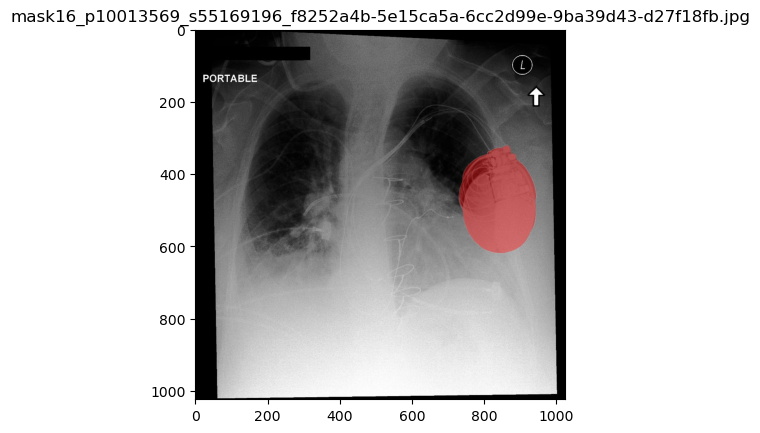

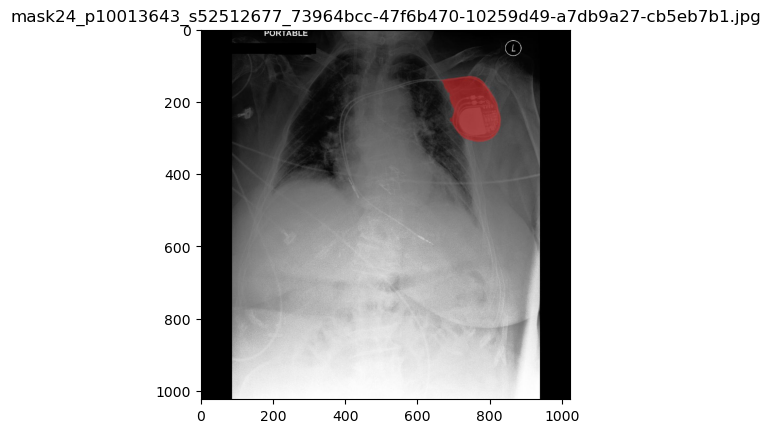

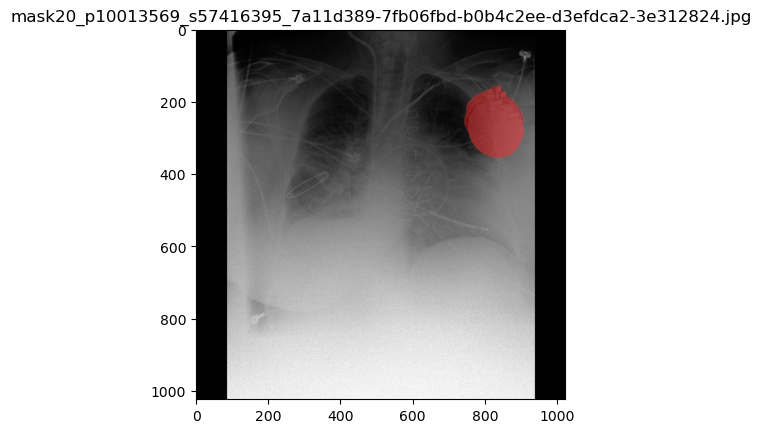

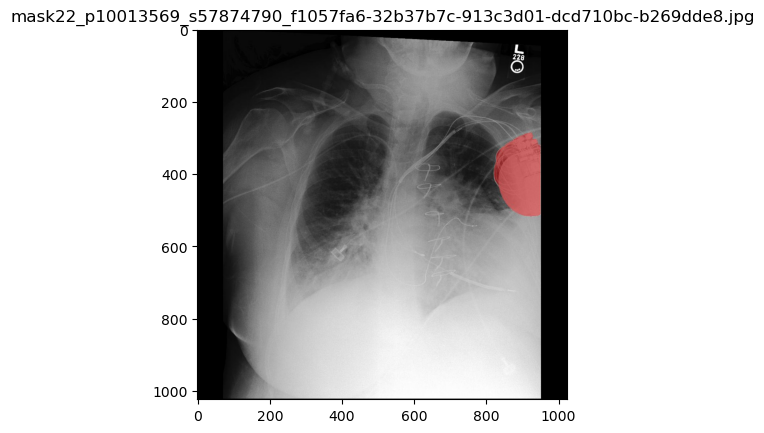

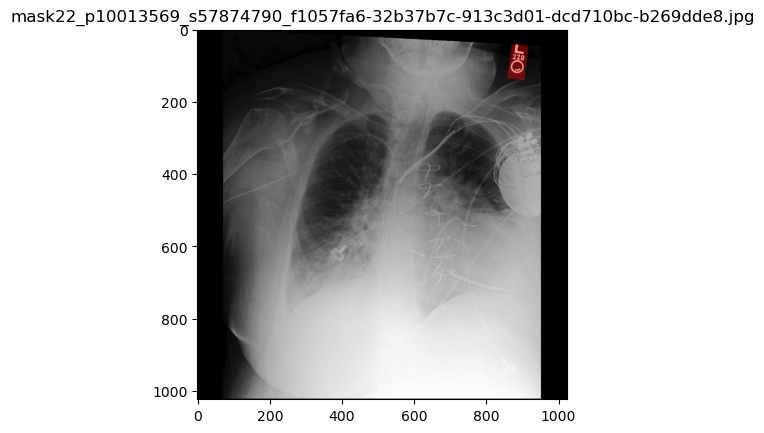

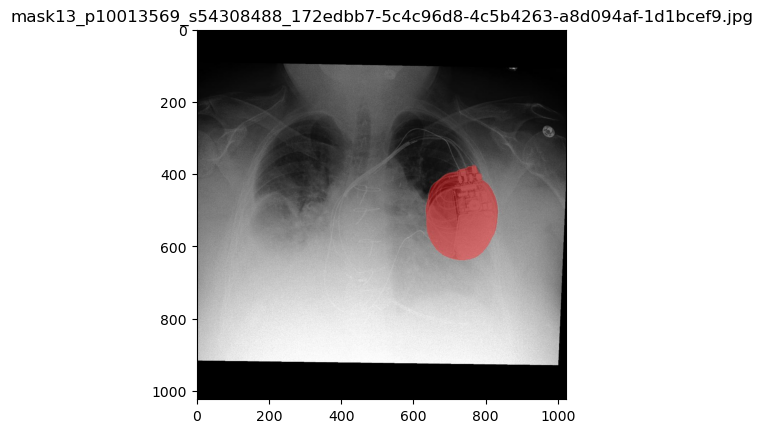

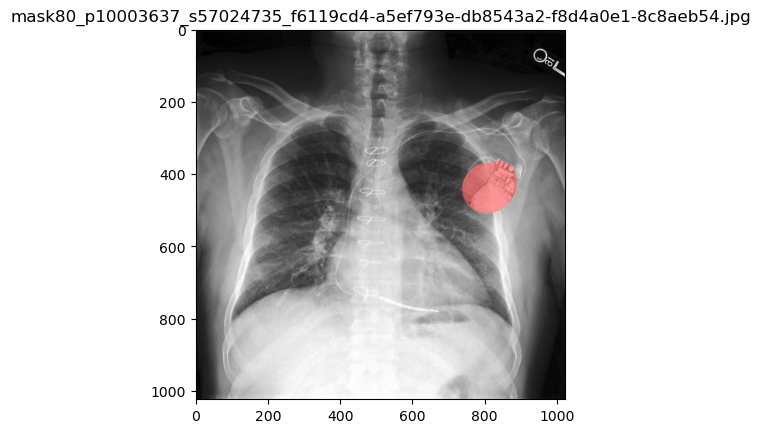

In [23]:
for img_path in img_paths[s]: 
    p = img_path.split("/")[-1]
    mask_img_path = glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch1-copy/sam_masks_mimic-cxr_annotated/*/{p}", recursive = True)
    mask_img_path += glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch2-copy/sam_masks_mimic-cxr_annotated/*/{p}", recursive = True)
    for img_p in mask_img_path: 
        img = Image.open(img_p).convert("RGB")
        plt.title(p)
        plt.imshow(img)
        plt.show()

In [ ]:
for img_path in img_paths[s]: 
    p = img_path.split("/")[-1]
    mask_img_path = glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results/sam_masks_mimic-cxr_annotated/*/{p}", recursive = True)
    mask_img_path += glob(f"/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch2/sam_masks_mimic-cxr_annotated/*/{p}", recursive = True)
    for img_p in mask_img_path: 
        img = Image.open(img_p).convert("RGB")
        plt.imshow(img)
        plt.show()

In [57]:
# Validate that all parts are saved correctly 
dir = "/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-results-batch2-copy"

In [58]:
with open(dir + "/sam_masks_mimic-cxr_raw/group0/" + "mask0_p10012261_s55346787_4213995d-c489f4a4-b27d496c-7b7a26d2-9f73f253.pkl", "rb") as f: 
    raw_mask = pickle.load(f)

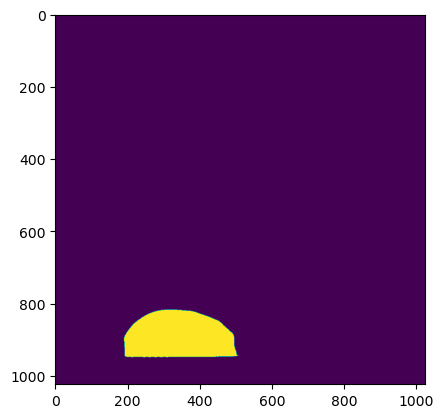

In [60]:
plt.imshow(raw_mask)
plt.show()

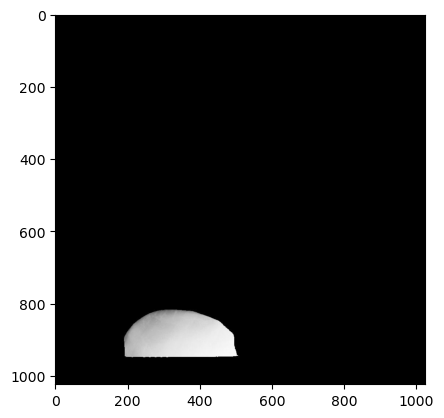

In [61]:
img = Image.open(dir + "/sam_masks_mimic-cxr_black/group0/" + "mask0_p10012261_s55346787_4213995d-c489f4a4-b27d496c-7b7a26d2-9f73f253.jpg").convert("RGB")
plt.imshow(img)
plt.show()

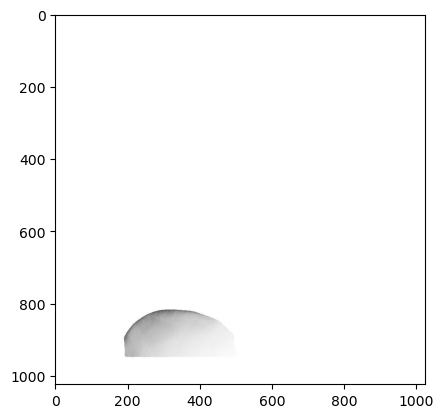

In [62]:
img = Image.open(dir + "/sam_masks_mimic-cxr_white/group0/" + "mask0_p10012261_s55346787_4213995d-c489f4a4-b27d496c-7b7a26d2-9f73f253.jpg").convert("RGB")
plt.imshow(img)
plt.show()

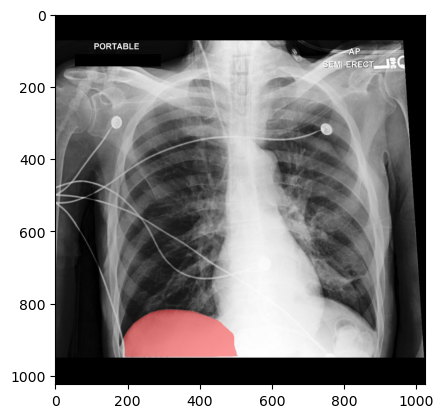

In [63]:
img = Image.open(dir + "/sam_masks_mimic-cxr_annotated/group0/" + "mask0_p10012261_s55346787_4213995d-c489f4a4-b27d496c-7b7a26d2-9f73f253.jpg").convert("RGB")
plt.imshow(img)
plt.show()

In [64]:
img_dir = "/data/healthy-ml/gobi1/data/MIMIC-CXR-JPG/files_preprocessed_1024/"

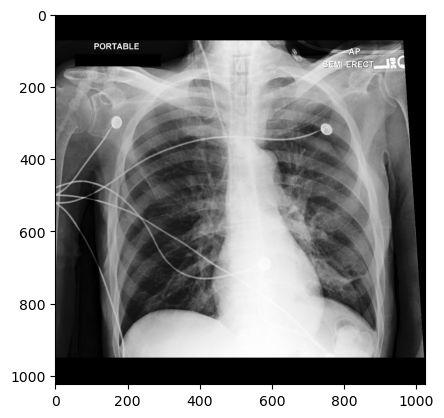

In [65]:
# Original 1024x1024 image 
img = Image.open(img_dir + "/p10/p10012261/s55346787/4213995d-c489f4a4-b27d496c-7b7a26d2-9f73f253.jpg").convert("RGB")
plt.imshow(img)
plt.show()

In [24]:
# Load the images in dataset 
data_dir = "/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training"
subdirs = glob(data_dir + "/*/", recursive = True)

In [25]:
subdirs

['/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/L-whole_L/',
 '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/pacemaker_pacemaker/',
 '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/metal-leads_lead/',
 '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/portable-left_portable/',
 '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/R-whole_R/',
 '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/L-circle_L/']

In [33]:
targetdirs = {}
feature_names = {}
init_tokens = {} 
savedirs = {}

count = 0
for s in subdirs:  
    feature_name = s.split("/")[-2].split("_")[0]
    init_token = s.split("/")[-2].split("_")[1]

    feature_names[count] = feature_name 
    init_tokens[count] = init_token 
    targetdirs[count] = s 
    savedirs[count] = output_dir + f"/{feature_name}_{init_token}"
    count += 1 

In [34]:
targetdirs

{0: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/L-whole_L/',
 1: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/pacemaker_pacemaker/',
 2: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/metal-leads_lead/',
 3: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/portable-left_portable/',
 4: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/R-whole_R/',
 5: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/L-circle_L/'}

In [35]:
feature_names

{0: 'L-whole',
 1: 'pacemaker',
 2: 'metal-leads',
 3: 'portable-left',
 4: 'R-whole',
 5: 'L-circle'}

In [36]:
init_tokens

{0: 'L', 1: 'pacemaker', 2: 'lead', 3: 'portable', 4: 'R', 5: 'L'}

In [37]:
savedirs

{0: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/L-whole_L',
 1: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/pacemaker_pacemaker',
 2: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/metal-leads_lead',
 3: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/portable-left_portable',
 4: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/R-whole_R',
 5: '/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/L-circle_L'}

In [40]:
dataset_name = "mimic-cxr"

model_name = "roentgen"
model_path = "/data/healthy-ml/scratch/qixuanj/generative_validation/roentgen"

program_list = []
for i, savedir in savedirs.items(): 
    datadir = targetdirs[i]
    feature_name = feature_names[i]
    c = dataset_name
    
    program_list.append(f'''accelerate launch /data/healthy-ml/scratch/qixuanj/generative_validation/diffusers/examples/dreambooth/train_dreambooth.py \
    --train_text_encoder \
    --instance_data_dir="{datadir}" \
    --pretrained_model_name_or_path="{model_path}" \
    --output_dir="{savedir}" \
    --instance_prompt="a photo of <{c}-{feature_name}>" \
    --resolution=512 \
    --snr_gamma=5.0 \
    --learning_rate=1.0e-06 \
    --lr_scheduler="constant" \
    --max_train_steps=2500 \
    --checkpointing_steps=500 \
    --seed=0 \
    --gradient_accumulation_steps=4 \
    --train_batch_size=2 \
    --validation_prompt="a photo of <{c}-{feature_name}>" \
    --num_validation_images=3 \
    --validation_steps=500 \
    --report_to="wandb" ''')

In [42]:
program_list[0]

'accelerate launch /data/healthy-ml/scratch/qixuanj/generative_validation/diffusers/examples/dreambooth/train_dreambooth.py     --train_text_encoder     --instance_data_dir="/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/L-whole_L/"     --pretrained_model_name_or_path="/data/healthy-ml/scratch/qixuanj/generative_validation/roentgen"     --output_dir="/data/healthy-ml/scratch/qixuanj/generative_validation/mimic-cxr-dreambooth-training/L-whole_L"     --instance_prompt="a photo of <mimic-cxr-L-whole>"     --resolution=512     --snr_gamma=5.0     --learning_rate=1.0e-06     --lr_scheduler="constant"     --max_train_steps=2500     --checkpointing_steps=500     --seed=0     --gradient_accumulation_steps=4     --train_batch_size=2     --validation_prompt="a photo of <mimic-cxr-L-whole>"     --num_validation_images=3     --validation_steps=500     --report_to="wandb" '